<center><h1> Uncovering the significance of diurnal variations and mesoscale impacts in ocean CO<sub>2</sub> fluxes </h1></center>
    
<center><h3> Preparation of Chapter 2 manuscript </h3></center>

<div style="text-align: right"><i> Louise Delaigue - February 2024</i></div>

### Research question

How do short-term changes and mesoscale variability in surface ocean pH influence CO<sub>2</sub> sequestration and release between the ocean and atmosphere?

### How does the study answer the research question?

High-frequency pH measurements uncover significant diurnal variations and the variable impact of external processes on ocean pH, revealing that traditional single-sample methods may not accurately capture CO<sub>2</sub> fluxes.

# 1 - Import libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

Import all libraries and functions that we need for the processing and analysis

In [4]:
# Standard library imports
import os
import pathlib
from datetime import timedelta
from datetime import datetime

# Data manipulation and analysis
import numpy as np
import pandas as pd
import xarray as xr

# Scientific computing and signal processing
from scipy import fftpack
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker


# Specific scientific libraries
import PyCO2SYS as pyco2
import gsw
import pyseaflux
import ephem
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from haversine import haversine, Unit
import copernicusmarine as cm


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.optimize import fsolve

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors



# 2- Define working paths

## **Important** - Paths and Directories

| Name | Variable | Purpose |
| ---| --- | --- |
| Project | `PROJECT_PATH` | top level directory for the project |
| Processed Data | `DATA_PATH` | where the  data is stored |
| Figures | `FIG_PATH` | where we store any plotted figures during any part of the analysis|


In [5]:
# Define the top level directory
PROJECT_PATH = pathlib.Path("C:/Users/ldelaigue/Documents/GitHub/high-resolution-ph/")
DATA_PATH = PROJECT_PATH.joinpath("C:/Users/ldelaigue/Documents/GitHub/high-resolution-ph/data/")
FIG_PATH = PROJECT_PATH.joinpath("C:/Users/ldelaigue/Documents/GitHub/high-resolution-ph/figs/")

if not os.path.exists(DATA_PATH):
      os.makedirs(DATA_PATH)
if not os.path.exists(FIG_PATH):
      os.makedirs(FIG_PATH)

# 3 - Convert UTC to Local Solar Time (LST)

In [6]:
north_atlantic = pd.read_csv('data/SO279/SO279_processed.csv')
south_pacific = pd.read_csv('data/SO289/SO289_processed.csv')

In [7]:
# Convert the "datetime" column to datetime objects
north_atlantic["datetime"] = pd.to_datetime(north_atlantic["datetime"])
south_pacific["datetime"] = pd.to_datetime(south_pacific["datetime"])

In [8]:
# Function to convert UTC to local solar time
def convert_to_lst(df):
    df["Longitude_mean"] = df.groupby(df.datetime.dt.date)["Longitude"].transform("mean")
    df["time_offset"] = (df["Longitude_mean"] / 15).astype(int)
    df["datetime_lst"] = df["datetime"] + df["time_offset"].apply(lambda x: timedelta(hours=x))
    return df

In [9]:
# Convert UTC to local solar time for both datasets
north_atlantic = convert_to_lst(north_atlantic)
south_pacific = convert_to_lst(south_pacific)

In [10]:
south_pacific

EXPOCODE Cruise_ID  Year_UTC  Month_UTC  Day_UTC  Time_UTC  \
0      06S220220218     SO289      2022          2       28  16:20:28   
1      06S220220218     SO289      2022          2       28  16:20:43   
2      06S220220218     SO289      2022          2       28  16:20:58   
3      06S220220218     SO289      2022          2       28  16:21:13   
4      06S220220218     SO289      2022          2       28  16:21:28   
...             ...       ...       ...        ...      ...       ...   
78028  06S220220218     SO289      2022          3       31  21:28:59   
78029  06S220220218     SO289      2022          3       31  21:29:14   
78030  06S220220218     SO289      2022          3       31  21:29:29   
78031  06S220220218     SO289      2022          3       31  21:29:44   
78032  06S220220218     SO289      2022          3       31  21:29:59   

        Latitude   Longitude  Depth  Temperature  ...  fco2_unc  smb_chl  \
0     -32.683333  -82.007222      3      19.8916  ...  7.910734    0.124   
1     -32.682222  -82.015000      3      19.8912  ...  7.910767    0.124   
2     -32.681389  -82.021667      3      19.8914  ...  7.909076    0.124   
3     -32.680556  -82.028889      3      19.8927  ...  7.910102    0.117   
4     -32.679444  -82.035833      3      19.8914  ...  7.886503    0.131   
...          ...         ...    ...          ...  ...       ...      ...   
78028 -25.740833 -178.948056      3      25.6646  ...  8.344178    0.044   
78029 -25.740833 -178.948056      3      25.6639  ...  8.365595    0.036   
78030 -25.740833 -178.948056      3      25.6661  ...  8.345924    0.036   
78031 -25.740833 -178.948056      3      25.6710  ...  8.345818    0.044   
78032 -25.740833 -178.948056      3      25.6763  ...  8.349817    0.044   

       wind_speed  smb_tur  air_pressure_hpa    SLA     thetao  \
0             9.4    0.282            1026.0  0.141  20.210442   
1             9.2    0.286            1025.9  0.141  20.210442   
2            10.6    0.286            1026.1  0.141  20.210442   
3            10.0    0.288            1025.8  0.141  20.210442   
4            10.1    0.290            1026.1  0.141  20.210442   
...           ...      ...               ...    ...        ...   
78028         4.3    0.211            1012.4  0.141  25.346685   
78029         4.4    0.214            1012.4  0.141  25.346685   
78030         3.2    0.218            1012.5  0.141  25.346685   
78031         3.3    0.216            1012.5  0.141  25.346685   
78032         4.8    0.211            1012.5  0.141  25.346685   

       Longitude_mean  time_offset        datetime_lst  
0          -82.239567           -5 2022-02-28 11:20:28  
1          -82.239567           -5 2022-02-28 11:20:43  
2          -82.239567           -5 2022-02-28 11:20:58  
3          -82.239567           -5 2022-02-28 11:21:13  
4          -82.239567           -5 2022-02-28 11:21:28  
...               ...          ...                 ...  
78028     -177.695622          -11 2022-03-31 10:28:59  
78029     -177.695622          -11 2022-03-31 10:29:14  
78030     -177.695622          -11 2022-03-31 10:29:29  
78031     -177.695622          -11 2022-03-31 10:29:44  
78032     -177.695622          -11 2022-03-31 10:29:59  

[78033 rows x 31 columns]

# 5 - Mean diurnal cycles

The below function only keeps cycles that have at least one measurement for every hour from midnight to midnight, not any consecutive 24 hours. It groups the data by the date and then checks if all hours (0 to 23) are represented in each group. If a group (which represents a day) has at least one measurement for each hour of the day, then it is considered a complete cycle 
and is included in the output list. If a cycle does not have at least one measurement for each hour from midnight to midnight, it will not be included in the output.

In [11]:
# Function to get complete cycles from the data
def get_complete_cycles(df):
    complete_cycles = []
    for group_key, group_data in df.groupby(df.datetime_lst.dt.date):
        if all(hour in group_data.datetime_lst.dt.hour.values for hour in range(24)):
            complete_cycles.append(group_data)
    return complete_cycles

# Get complete cycles for both datasets
north_atlantic_complete_cycles = get_complete_cycles(north_atlantic)
south_pacific_complete_cycles = get_complete_cycles(south_pacific)

In [12]:
len(north_atlantic_complete_cycles)

7

In [13]:
north_atlantic_complete_cycles[6]

EXPOCODE Cruise_ID  Year_UTC  Month_UTC  Day_UTC  Time_UTC  \
37979  06SN20201204     SO279      2020         12       29  01:00:22   
37980  06SN20201204     SO279      2020         12       29  01:00:52   
37981  06SN20201204     SO279      2020         12       29  01:01:22   
37982  06SN20201204     SO279      2020         12       29  01:01:52   
37983  06SN20201204     SO279      2020         12       29  01:02:22   
...             ...       ...       ...        ...      ...       ...   
40842  06SN20201204     SO279      2020         12       30  00:57:52   
40843  06SN20201204     SO279      2020         12       30  00:58:22   
40844  06SN20201204     SO279      2020         12       30  00:58:52   
40845  06SN20201204     SO279      2020         12       30  00:59:22   
40846  06SN20201204     SO279      2020         12       30  00:59:52   

        Latitude  Longitude  Depth  Temperature  ...   fco2_unc  smb_chl  \
37979  36.160278 -19.956389    3.0      17.3177  ...  12.177282    0.467   
37980  36.176944 -20.198611    3.0      17.3138  ...  12.233507    0.467   
37981  36.194167 -20.180000    3.0      17.3156  ...  12.224559    0.467   
37982  35.950000 -20.161389    3.0      17.3232  ...  12.279748    0.467   
37983  35.967222 -20.143056    3.0      17.3280  ...  12.219715    0.467   
...          ...        ...    ...          ...  ...        ...      ...   
40842  39.001667 -16.960278    3.0      16.5376  ...   8.517863    0.453   
40843  39.018611 -16.942500    3.0      16.5237  ...   8.509813    0.467   
40844  38.774722 -16.924167    3.0      16.5159  ...   8.530060    0.445   
40845  38.791944 -16.906111    3.0      16.5150  ...   8.508037    0.474   
40846  38.808889 -16.887500    3.0      16.5150  ...   8.460944    0.474   

       wind_speed  smb_tur            datetime     SLA     thetao  \
37979         8.1    2.191 2020-12-29 01:00:22  0.0789  17.568705   
37980         8.6    3.281 2020-12-29 01:00:52  0.0952  17.593126   
37981        10.3    2.191 2020-12-29 01:01:22  0.0952  17.593126   
37982         9.1    2.213 2020-12-29 01:01:52  0.0941  17.615717   
37983         9.5    2.230 2020-12-29 01:02:22  0.0941  17.627140   
...           ...      ...                 ...     ...        ...   
40842         6.9    2.582 2020-12-30 00:57:52  0.1288  16.014252   
40843         6.3    3.067 2020-12-30 00:58:22  0.1288  16.094770   
40844         8.5    3.103 2020-12-30 00:58:52  0.1224  16.317318   
40845         9.4    2.940 2020-12-30 00:59:22  0.1224  16.094120   
40846         7.8    2.906 2020-12-30 00:59:52  0.1224  16.094120   

       Longitude_mean  time_offset        datetime_lst  
37979      -18.612613           -1 2020-12-29 00:00:22  
37980      -18.612613           -1 2020-12-29 00:00:52  
37981      -18.612613           -1 2020-12-29 00:01:22  
37982      -18.612613           -1 2020-12-29 00:01:52  
37983      -18.612613           -1 2020-12-29 00:02:22  
...               ...          ...                 ...  
40842      -15.603059           -1 2020-12-29 23:57:52  
40843      -15.603059           -1 2020-12-29 23:58:22  
40844      -15.603059           -1 2020-12-29 23:58:52  
40845      -15.603059           -1 2020-12-29 23:59:22  
40846      -15.603059           -1 2020-12-29 23:59:52  

[2868 rows x 31 columns]

### Calculate expected pH

In [14]:
def clean_and_prepare_data(df):
    # Ensure correct data types and handle NaN values
    numeric_columns = ['Temperature', 'Salinity', 'talk', 'tco2', 'tco2_unc', 'fco2']
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df.dropna(subset=numeric_columns, inplace=True)  # Drop rows where any critical numeric column is NaN
    
    # Convert datetime if necessary and extract the hour
    if 'datetime' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df['Hour'] = df['datetime'].dt.hour

    return df

def apply_pH_to_dataframe(df):
    df = clean_and_prepare_data(df)
    # Group by hour before applying calculations
    grouped_df = df.groupby('Hour').mean()

    # Apply pH calculations on grouped data
    grouped_df = grouped_df.apply(lambda row: calculate_row_pH(row, grouped_df['talk'].mean(), grouped_df['tco2'].mean(), 
                                                               grouped_df['fco2'].mean(), grouped_df['Temperature'].mean(), 
                                                               grouped_df['Salinity'].mean()), axis=1)

    # Calculate pH_cycle_mean
    pH_cycle_mean = grouped_df['pH_TS_measured (optode)'].mean()
    grouped_df['pH_cycle_mean'] = pH_cycle_mean

    return grouped_df

def calculate_row_pH(row, mean_TA, mean_DIC, mean_fco2, mean_temperature, mean_salinity):
    # Initialize the results in case of exceptions
    row['pH_temp_sal'] = np.nan
    row['pH_temp'] = np.nan
    row['pH_sal'] = np.nan
    row['pH_TA_DIC'] = np.nan
    row['pH_TA_fco2'] = np.nan

    try:
        # Temperature/Salinity based pH calculation
        temp_sal_result = pyco2.sys(
            par1=float(mean_TA), par2=float(mean_DIC), par1_type=1, par2_type=2,
            salinity=float(row['Salinity']), temperature=float(row['Temperature']), pressure=0
        )
        row['pH_temp_sal'] = temp_sal_result['pH_total']

        # Temperature fluctuation based pH calculation
        temp_fluct_result = pyco2.sys(
            par1=float(mean_TA), par2=float(mean_DIC), par1_type=1, par2_type=2,
            salinity=float(mean_salinity), temperature=float(row['Temperature']), pressure=0
        )
        row['pH_temp'] = temp_fluct_result['pH_total']

        # Salinity fluctuation based pH calculation
        sal_fluct_result = pyco2.sys(
            par1=float(mean_TA), par2=float(mean_DIC), par1_type=1, par2_type=2,
            salinity=float(row['Salinity']), temperature=float(mean_temperature), pressure=0
        )
        row['pH_sal'] = sal_fluct_result['pH_total']

        # Mean DIC and TA based pH calculation
        dic_ta_result = pyco2.sys(
            par1=float(mean_TA), par2=float(mean_DIC), par1_type=1, par2_type=2,
            salinity=float(row['Salinity']), temperature=float(row['Temperature']), pressure=0
        )
        row['pH_TA_DIC'] = dic_ta_result['pH_total']

        # Mean TA and fco2 based pH calculation
        ta_fco2_result = pyco2.sys(
            par1=float(mean_TA), par2=float(mean_fco2), par1_type=1, par2_type=4,
            salinity=float(row['Salinity']), temperature=float(row['Temperature']), pressure=0
        )
        row['pH_TA_fco2'] = ta_fco2_result['pH_total']

    except Exception as e:
        print(f"Error processing row: {e}")

    return row

def calculate_pH_global(dfs):
    # Combine Expected_pH from all DataFrames to calculate global mean
    all_pH_values = pd.concat([df['pH_TS_measured (optode)'] for df in dfs])
    pH_global = all_pH_values.mean()
    return pH_global

# Apply pH calculations and calculate pH_cycle_mean for each DataFrame
for i in range(len(north_atlantic_complete_cycles)):
    north_atlantic_complete_cycles[i] = apply_pH_to_dataframe(north_atlantic_complete_cycles[i])

for i in range(len(south_pacific_complete_cycles)):
    south_pacific_complete_cycles[i] = apply_pH_to_dataframe(south_pacific_complete_cycles[i])

# Calculate pH_global for each basin separately
pH_global_north_atlantic = calculate_pH_global(north_atlantic_complete_cycles)
pH_global_south_pacific = calculate_pH_global(south_pacific_complete_cycles)

# Add pH_global to each DataFrame in their respective basins
for df in north_atlantic_complete_cycles:
    df['pH_global'] = pH_global_north_atlantic

for df in south_pacific_complete_cycles:
    df['pH_global'] = pH_global_south_pacific


In [15]:
north_atlantic_complete_cycles[0].columns

Index(['Year_UTC', 'Month_UTC', 'Day_UTC', 'Latitude', 'Longitude', 'Depth',
       'Temperature', 'TEMP_pH', 'Salinity', 'Salinity_flag',
       'pH_TS_measured (optode)', 'pH_TS_measured (optode) uncertainty',
       'pH_flag', 'datenum', 'talk', 'tco2', 'tco2_unc', 'fco2', 'fco2_unc',
       'smb_chl', 'wind_speed', 'smb_tur', 'SLA', 'thetao', 'Longitude_mean',
       'time_offset', 'pH_temp_sal', 'pH_temp', 'pH_sal', 'pH_TA_DIC',
       'pH_TA_fco2', 'pH_cycle_mean', 'pH_global'],
      dtype='object')

## Correlation matrix for each cycle

###  North Atlantic Region

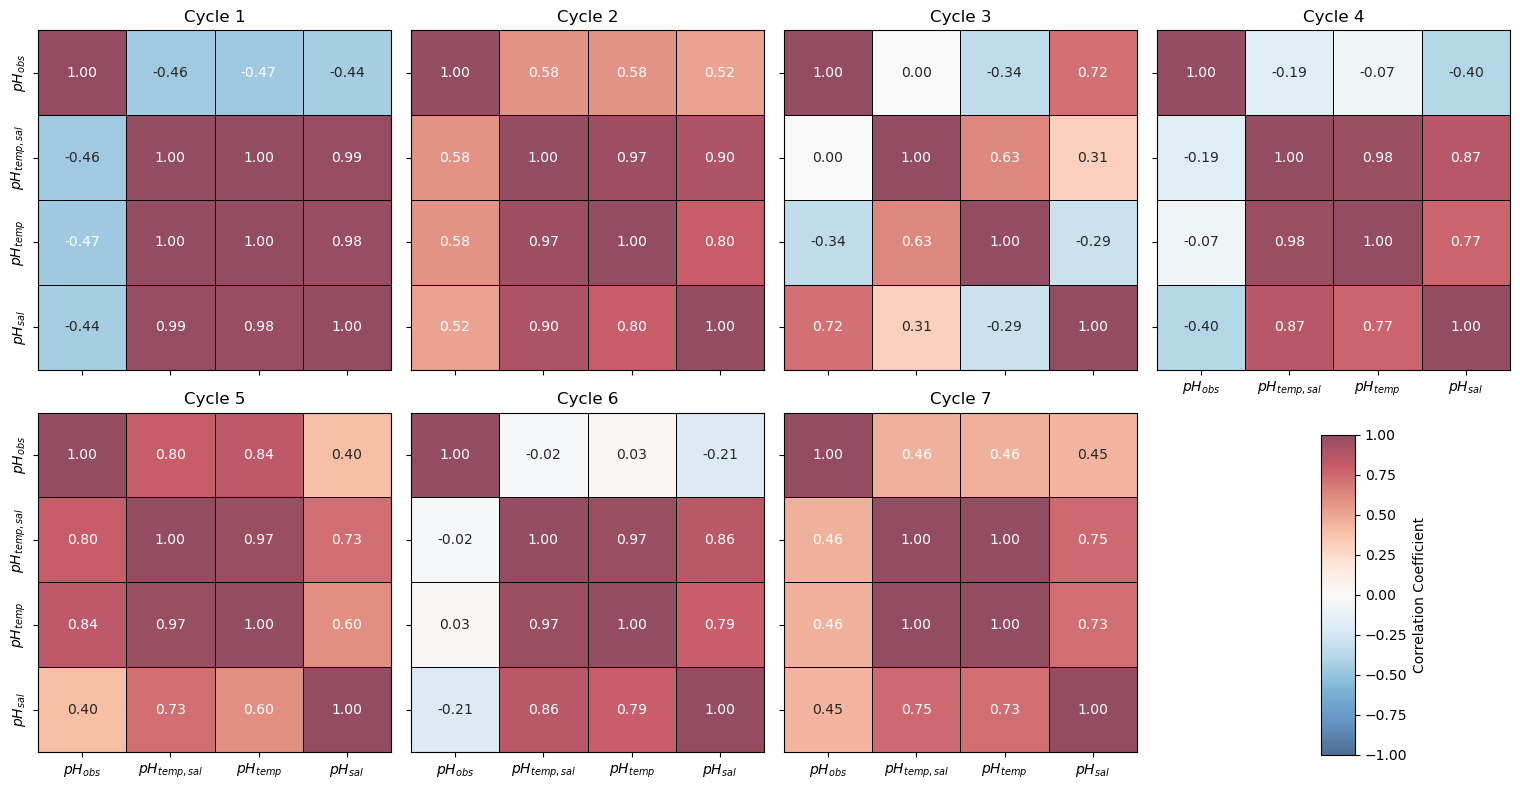

In [16]:
# Select the variables of interest for correlation analysis
variables_of_interest = [
    'pH_TS_measured (optode)',    # pH measured (optode)
    'pH_temp_sal',                # pH calculated with temperature and salinity
    'pH_temp',                    # pH calculated with temperature fluctuation
    'pH_sal'                      # pH calculated with salinity fluctuation
]

# Function to compute the correlation matrix for a DataFrame
def compute_corr_matrix(df):
    return df[variables_of_interest].corr(method='spearman')

# Function to create and display correlation matrix heatmap for a list of DataFrames
def plot_corr_heatmaps(dfs):
    n_dfs = len(dfs)
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, df in enumerate(dfs):
        if i < 7:
            corr_matrix = compute_corr_matrix(df)
            sns.heatmap(corr_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$"],
                        yticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$"])
            axes[i].set_title(f"Cycle {i+1}")

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Hide the last axis, which is intended for the colorbar
    for ax in axes[7:]:
        ax.axis('off')

    # Choose which subplot can keep both axis
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels([])
    axes[2].set_xticklabels([])
    
    axes[1].set_yticklabels([])
    axes[2].set_yticklabels([])
    axes[3].set_yticklabels([])
    axes[5].set_yticklabels([])
    axes[6].set_yticklabels([])
    
    # Create a common color bar at the end
    cbar_ax = fig.add_axes([0.78, 0.05, 0.02, 0.4])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Correlation Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
#     plt.show()

# Plot the heatmaps for north_atlantic_complete_cycles
plot_corr_heatmaps(north_atlantic_complete_cycles[:7])

# Save the plot
plt.savefig(
    "figs/SO279_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

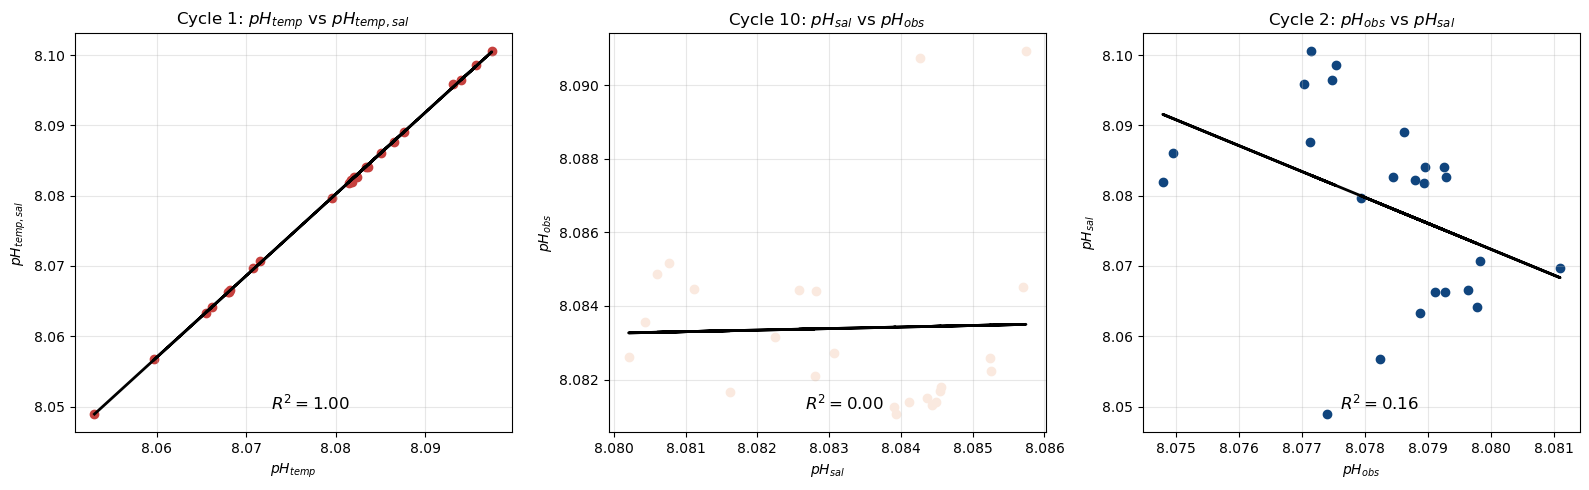

In [17]:
# Function to perform linear regression and plot results
def plot_linear_regression(ax, x, y, x_label, y_label, title, point_color):
    # Drop NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Perform linear regression
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))

    # Plot data points
    ax.scatter(x, y, color=point_color, label='Data points')
    
    # Plot regression line
    ax.plot(x, y_pred, color='k', linewidth=2, label='Regression line')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # Print R^2 score
    r2 = model.score(x.reshape(-1, 1), y)
    ax.text(0.45, 0.10, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')

# Initialize figure and axes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Get the RdBu colormap
rd_bu = plt.cm.get_cmap('RdBu', 256)

# Define colors for data points
color1 = rd_bu(245)  # Positive extreme
color2 = rd_bu(115)  # Middle
color3 = rd_bu(40)    # Negative extreme

# Subplot 1: Linear regression between pH_temp and pH_temp_sal for df 1
df1 = north_atlantic_complete_cycles[0]
x = df1['pH_temp'].values
y = df1['pH_temp_sal'].values
plot_linear_regression(axes[0], x, y, '$pH_{temp}$', '$pH_{temp, sal}$', 'Cycle 1: $pH_{temp}$ vs $pH_{temp, sal}$', color3)

# Subplot 2: Linear regression between pH_sal and pH_TS_measured (optode) for df 10
df10 = north_atlantic_complete_cycles[3]
x = df10['pH_TS_measured (optode)'].values
y = df10['pH_temp_sal'].values
plot_linear_regression(axes[1], x, y, '$pH_{sal}$', '$pH_{obs}$', 'Cycle 10: $pH_{sal}$ vs $pH_{obs}$', color2)

# Subplot 3: Linear regression between pH_TS_measured (optode) and pH_sal for df 2
df2 = north_atlantic_complete_cycles[0]
x = df2['pH_TS_measured (optode)'].values
y = df2['pH_temp_sal'].values
plot_linear_regression(axes[2], x, y, '$pH_{obs}$', '$pH_{sal}$', 'Cycle 2: $pH_{obs}$ vs $pH_{sal}$', color1)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO279_lin_regress_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()

### South Pacific Region

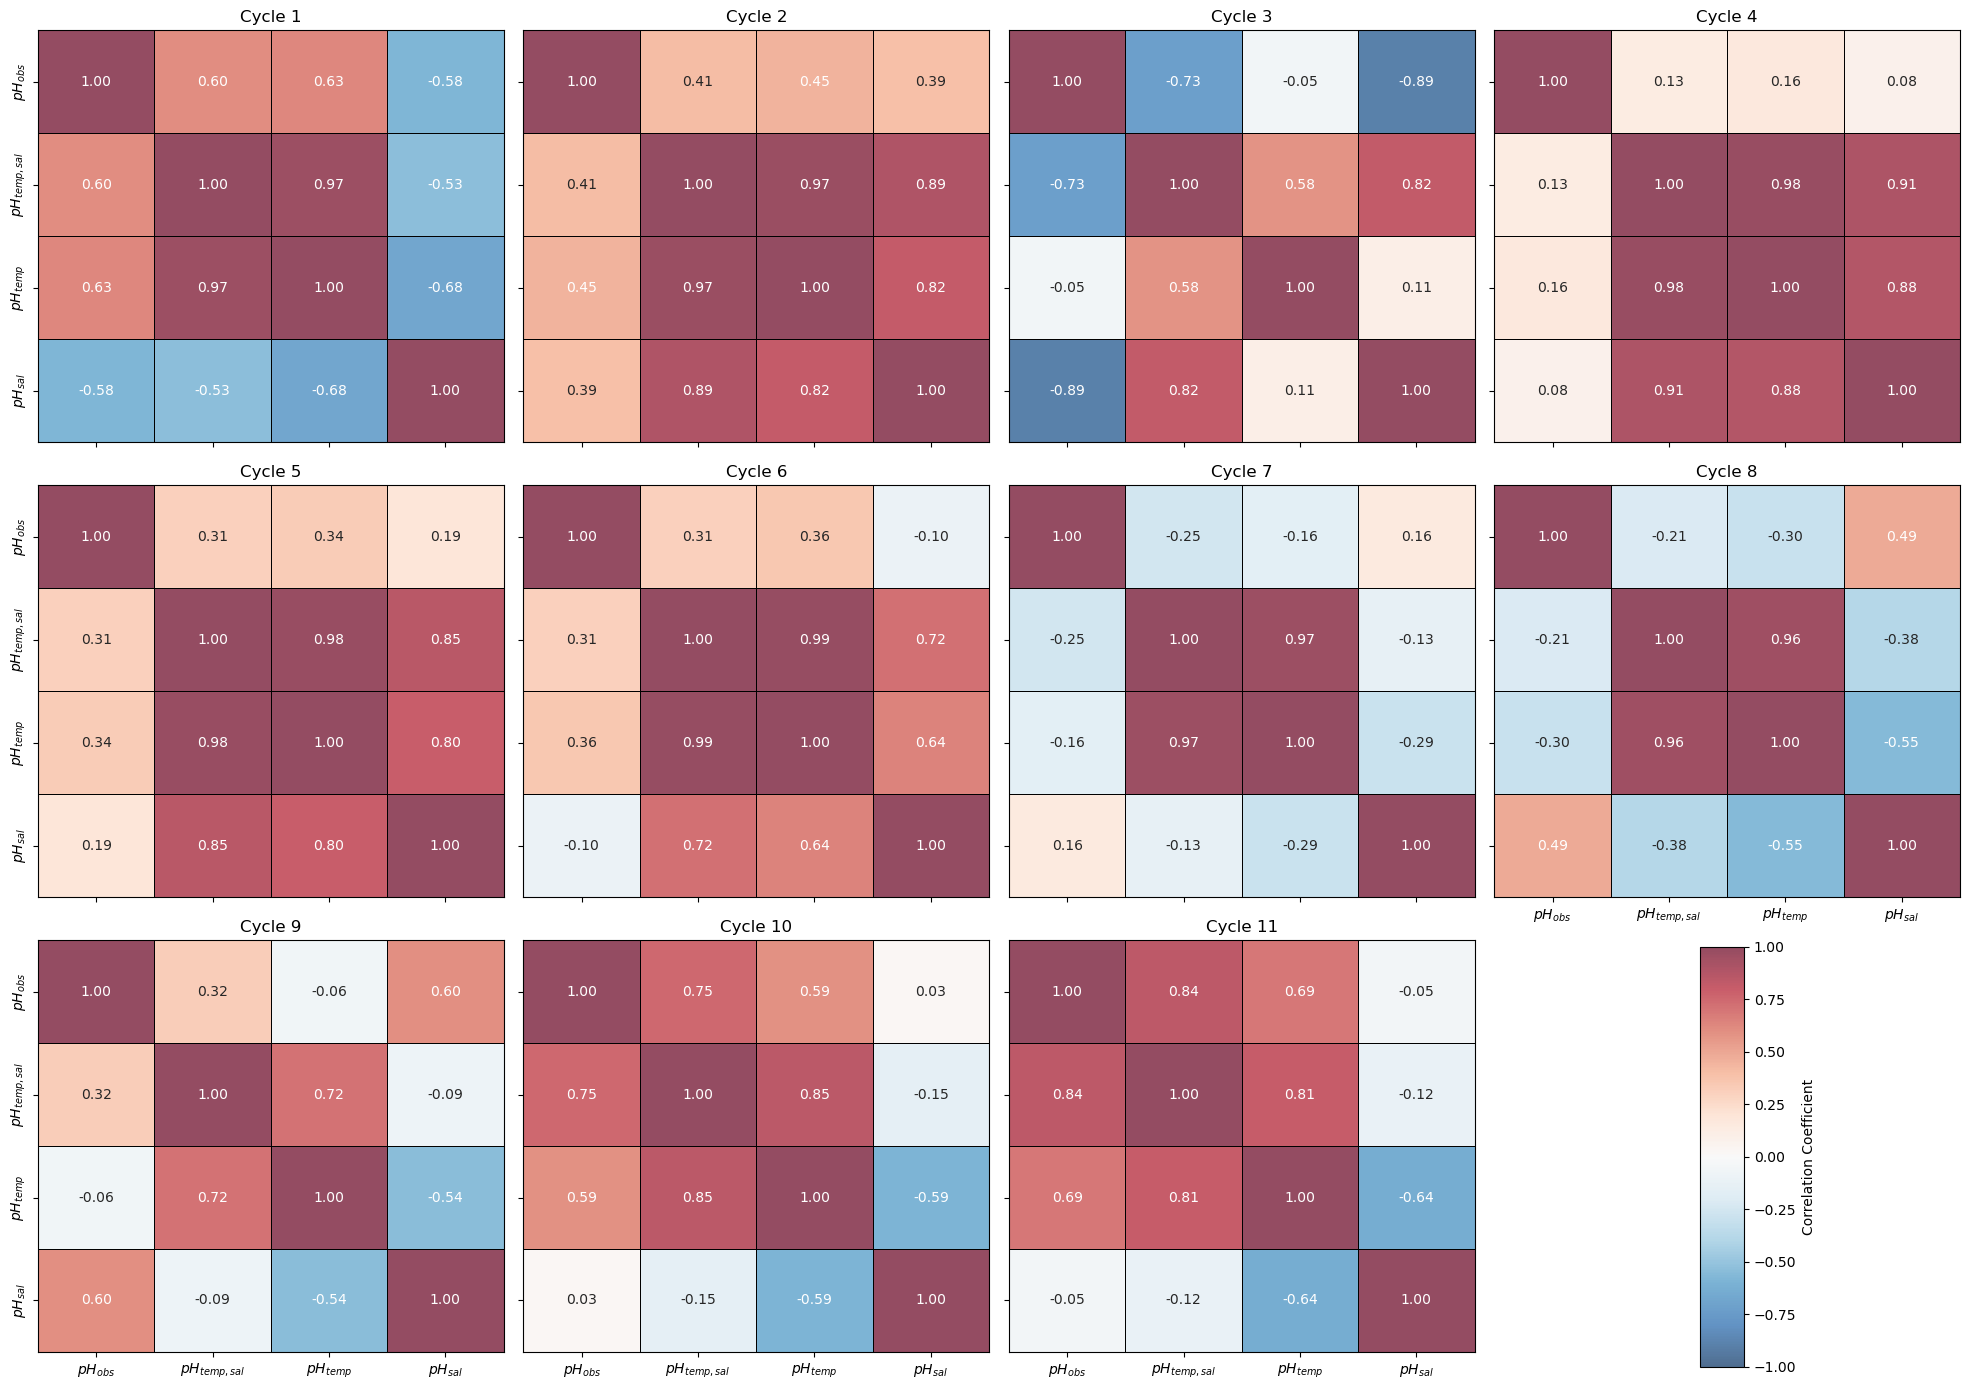

In [18]:
# Select the variables of interest for correlation analysis
variables_of_interest = [
    'pH_TS_measured (optode)',    # pH measured (optode)
    'pH_temp_sal',                # pH calculated with temperature and salinity
    'pH_temp',                    # pH calculated with temperature fluctuation
    'pH_sal'                      # pH calculated with salinity fluctuation
]

# Function to compute the correlation matrix for a DataFrame
def compute_corr_matrix(df):
    return df[variables_of_interest].corr(method="spearman")

# Function to create and display correlation matrix heatmap for a list of DataFrames
def plot_corr_heatmaps(dfs):
    n_dfs = len(dfs)
    fig, axes = plt.subplots(3, 4, figsize=(22, 14))
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, df in enumerate(dfs):
        if i < 11:
            corr_matrix = compute_corr_matrix(df)
            sns.heatmap(corr_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$"],
                        yticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$"])
            axes[i].set_title(f"Cycle {i+1}")

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Hide the last axis, which is intended for the colorbar
    for ax in axes[11:]:
        ax.axis('off')

    # Hide x-axis labels for specific plots
    for i in [0, 1, 2, 3, 4, 5, 6]:
        axes[i].set_xticklabels([])

    # Hide y-axis labels for specific plots
    for i in [1, 2, 3, 5, 6, 7, 9, 10]:
        axes[i].set_yticklabels([])

    # Create a common color bar in the last subplot
    cbar_ax = fig.add_axes([0.775, 0.02, 0.02, 0.3])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Correlation Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
#     plt.show()

# Plot the heatmaps for south_pacific_complete_cycles
plot_corr_heatmaps(south_pacific_complete_cycles[:11])

# Save the plot
plt.savefig(
    "figs/SO289_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

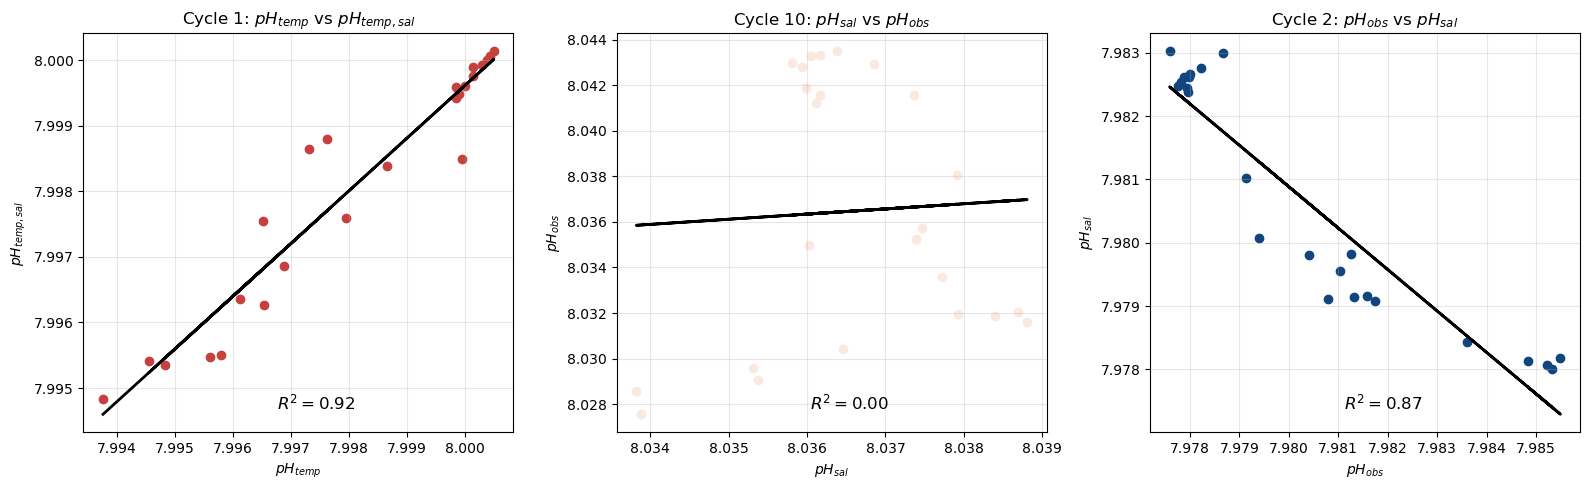

In [19]:
# Function to perform linear regression and plot results
def plot_linear_regression(ax, x, y, x_label, y_label, title, point_color):
    # Drop NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Perform linear regression
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))

    # Plot data points
    ax.scatter(x, y, color=point_color, label='Data points')
    
    # Plot regression line
    ax.plot(x, y_pred, color='k', linewidth=2, label='Regression line')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # Print R^2 score
    r2 = model.score(x.reshape(-1, 1), y)
    ax.text(0.45, 0.10, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')

# Initialize figure and axes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Get the RdBu colormap
rd_bu = plt.cm.get_cmap('RdBu', 256)

# Define colors for data points
color1 = rd_bu(245)  # Positive extreme
color2 = rd_bu(115)  # Middle
color3 = rd_bu(40)    # Negative extreme

# Subplot 1: Linear regression between pH_temp and pH_temp_sal for df 1
df1 = south_pacific_complete_cycles[0]
x = df1['pH_temp'].values
y = df1['pH_temp_sal'].values
plot_linear_regression(axes[0], x, y, '$pH_{temp}$', '$pH_{temp, sal}$', 'Cycle 1: $pH_{temp}$ vs $pH_{temp, sal}$', color3)

# Subplot 2: Linear regression between pH_sal and pH_TS_measured (optode) for df 10
df10 = south_pacific_complete_cycles[9]
x = df10['pH_sal'].values
y = df10['pH_TS_measured (optode)'].values
plot_linear_regression(axes[1], x, y, '$pH_{sal}$', '$pH_{obs}$', 'Cycle 10: $pH_{sal}$ vs $pH_{obs}$', color2)

# Subplot 3: Linear regression between pH_TS_measured (optode) and pH_sal for df 2
df2 = south_pacific_complete_cycles[2]
x = df2['pH_TS_measured (optode)'].values
y = df2['pH_sal'].values
plot_linear_regression(axes[2], x, y, '$pH_{obs}$', '$pH_{sal}$', 'Cycle 2: $pH_{obs}$ vs $pH_{sal}$', color1)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO289_lin_regress_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


## Same but using slope instead of Spearman

### North Atlantic Region

In [20]:
north_atlantic_complete_cycles[0].columns

Index(['Year_UTC', 'Month_UTC', 'Day_UTC', 'Latitude', 'Longitude', 'Depth',
       'Temperature', 'TEMP_pH', 'Salinity', 'Salinity_flag',
       'pH_TS_measured (optode)', 'pH_TS_measured (optode) uncertainty',
       'pH_flag', 'datenum', 'talk', 'tco2', 'tco2_unc', 'fco2', 'fco2_unc',
       'smb_chl', 'wind_speed', 'smb_tur', 'SLA', 'thetao', 'Longitude_mean',
       'time_offset', 'pH_temp_sal', 'pH_temp', 'pH_sal', 'pH_TA_DIC',
       'pH_TA_fco2', 'pH_cycle_mean', 'pH_global'],
      dtype='object')

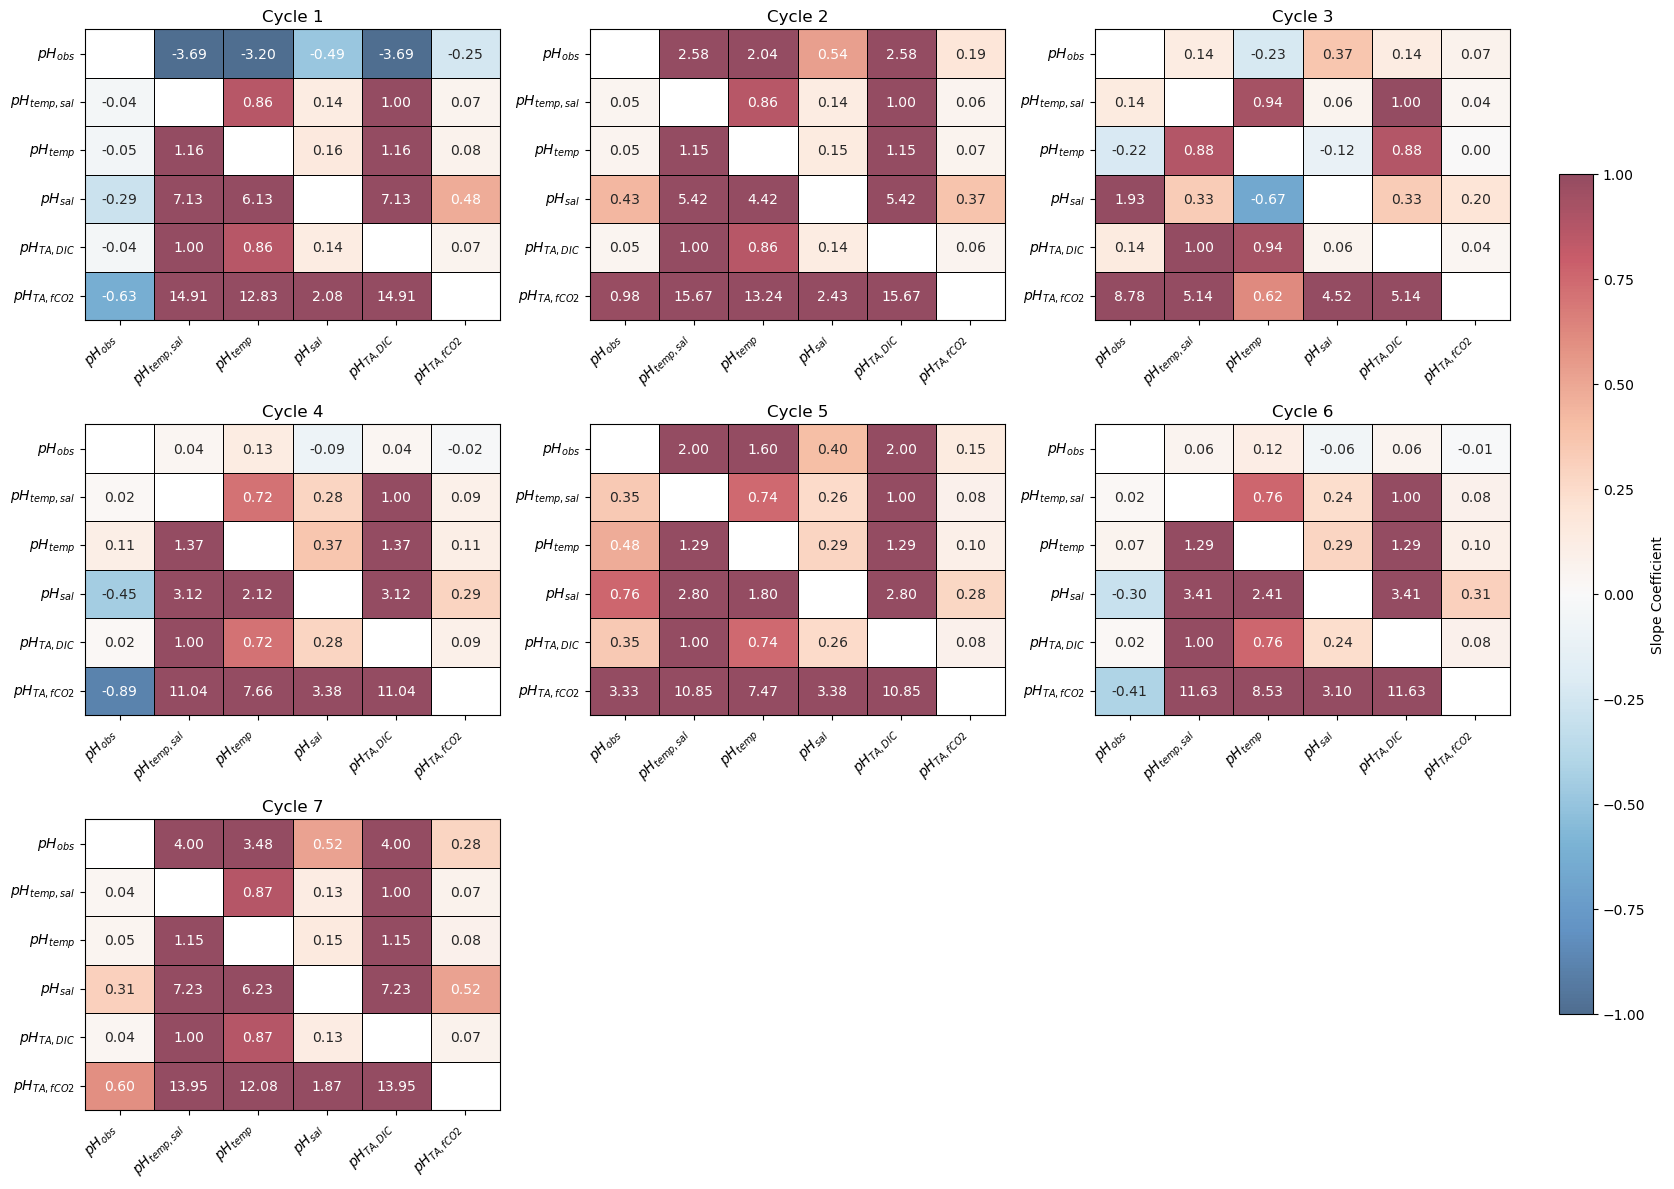

<Figure size 640x480 with 0 Axes>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Select the variables of interest for slope analysis
variables_of_interest = [
    'pH_TS_measured (optode)',    # pH measured (optode)
    'pH_temp_sal',                # pH calculated with temperature and salinity
    'pH_temp',                    # pH calculated with temperature fluctuation
    'pH_sal',                     # pH calculated with salinity fluctuation
    'pH_TA_DIC',                  # pH calculated with mean TA and mean DIC
    'pH_TA_fco2'                  # pH calculated with mean TA and mean fCO2
]

# Function to compute the slope matrix for a DataFrame
def compute_slope_matrix(df):
    slopes = pd.DataFrame(index=variables_of_interest, columns=variables_of_interest, dtype=float)
    for var1 in variables_of_interest:
        for var2 in variables_of_interest:
            if var1 != var2:
                # Drop NaN values before computing slope
                x = df[var1].values
                y = df[var2].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if np.sum(mask) > 1:  # Ensure there are enough points to fit a line
                    slope = np.polyfit(x[mask], y[mask], 1)[0]
                else:
                    slope = np.nan
                slopes.loc[var1, var2] = slope
            else:
                slopes.loc[var1, var2] = np.nan  # Diagonal elements set to NaN
    return slopes

# Function to create and display slope matrix heatmap for a list of DataFrames
def plot_slope_heatmaps(dfs):
    n_dfs = len(dfs)
    fig, axes = plt.subplots(3, 3, figsize=(17, 12))
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, df in enumerate(dfs):
        if i < 7:  # Plot only the first 7 cycles
            slope_matrix = compute_slope_matrix(df)
            mask = np.eye(len(slope_matrix), dtype=bool)  # Mask diagonal elements
            sns.heatmap(slope_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"],
                        yticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], mask=mask)
            axes[i].set_title(f"Cycle {i+1}")

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Hide the 8th axis (index 7), which is intended to be blank
    axes[7].axis('off')

    # Hide the last axis, which is intended for the colorbar
    axes[8].axis('off')

    # Show specific axis labels for clarity
    for ax in axes[:7]:
        ax.set_xticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=45, ha='right')
        ax.set_yticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=0)

    # Create a common color bar at the end
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Slope Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Plot the heatmaps for north_atlantic_complete_cycles
plot_slope_heatmaps(north_atlantic_complete_cycles[:7])

# Save the plot
plt.savefig(
    "figs/SO279_slope_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


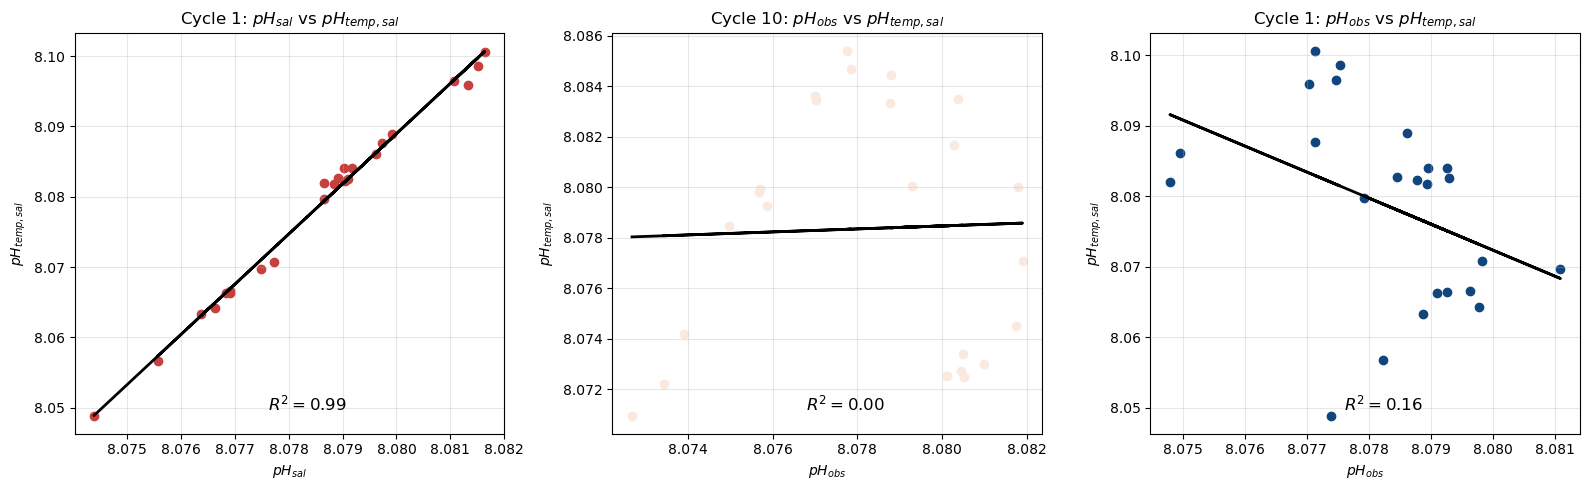

In [22]:
# Function to perform linear regression and plot results
def plot_linear_regression(ax, x, y, x_label, y_label, title, point_color):
    # Drop NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Perform linear regression
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))

    # Plot data points
    ax.scatter(x, y, color=point_color, label='Data points')
    
    # Plot regression line
    ax.plot(x, y_pred, color='k', linewidth=2, label='Regression line')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # Print R^2 score
    r2 = model.score(x.reshape(-1, 1), y)
    ax.text(0.45, 0.10, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')

# Initialize figure and axes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Get the RdBu colormap
rd_bu = plt.cm.get_cmap('RdBu', 256)

# Define colors for data points
color1 = rd_bu(245)  # Positive extreme
color2 = rd_bu(115)  # Middle
color3 = rd_bu(40)    # Negative extreme

# Subplot 1: Linear regression between pH_obs and pH_temp_sal for df 1
df1 = north_atlantic_complete_cycles[0]
x = df1['pH_sal'].values
y = df1['pH_temp_sal'].values
plot_linear_regression(axes[0], x, y, '$pH_{sal}$', '$pH_{temp, sal}$', 'Cycle 1: $pH_{sal}$ vs $pH_{temp, sal}$', color3)

# Subplot 2: Linear regression between pH_sal and pH_TS_measured (optode) for df 10
df10 = north_atlantic_complete_cycles[5]
x = df10['pH_TS_measured (optode)'].values
y = df10['pH_temp_sal'].values
plot_linear_regression(axes[1], x, y, '$pH_{obs}$', '$pH_{temp, sal}$', 'Cycle 10: $pH_{obs}$ vs $pH_{temp, sal}$', color2)

# Subplot 3: Linear regression between pH_TS_measured (optode) and pH_sal for df 2
df1 = north_atlantic_complete_cycles[0]
x = df1['pH_TS_measured (optode)'].values
y = df1['pH_temp_sal'].values
plot_linear_regression(axes[2], x, y, '$pH_{obs}$', '$pH_{temp, sal}$', 'Cycle 1: $pH_{obs}$ vs $pH_{temp, sal}$', color1)


# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO279_lin_regress_slope_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()

### South Pacific Region

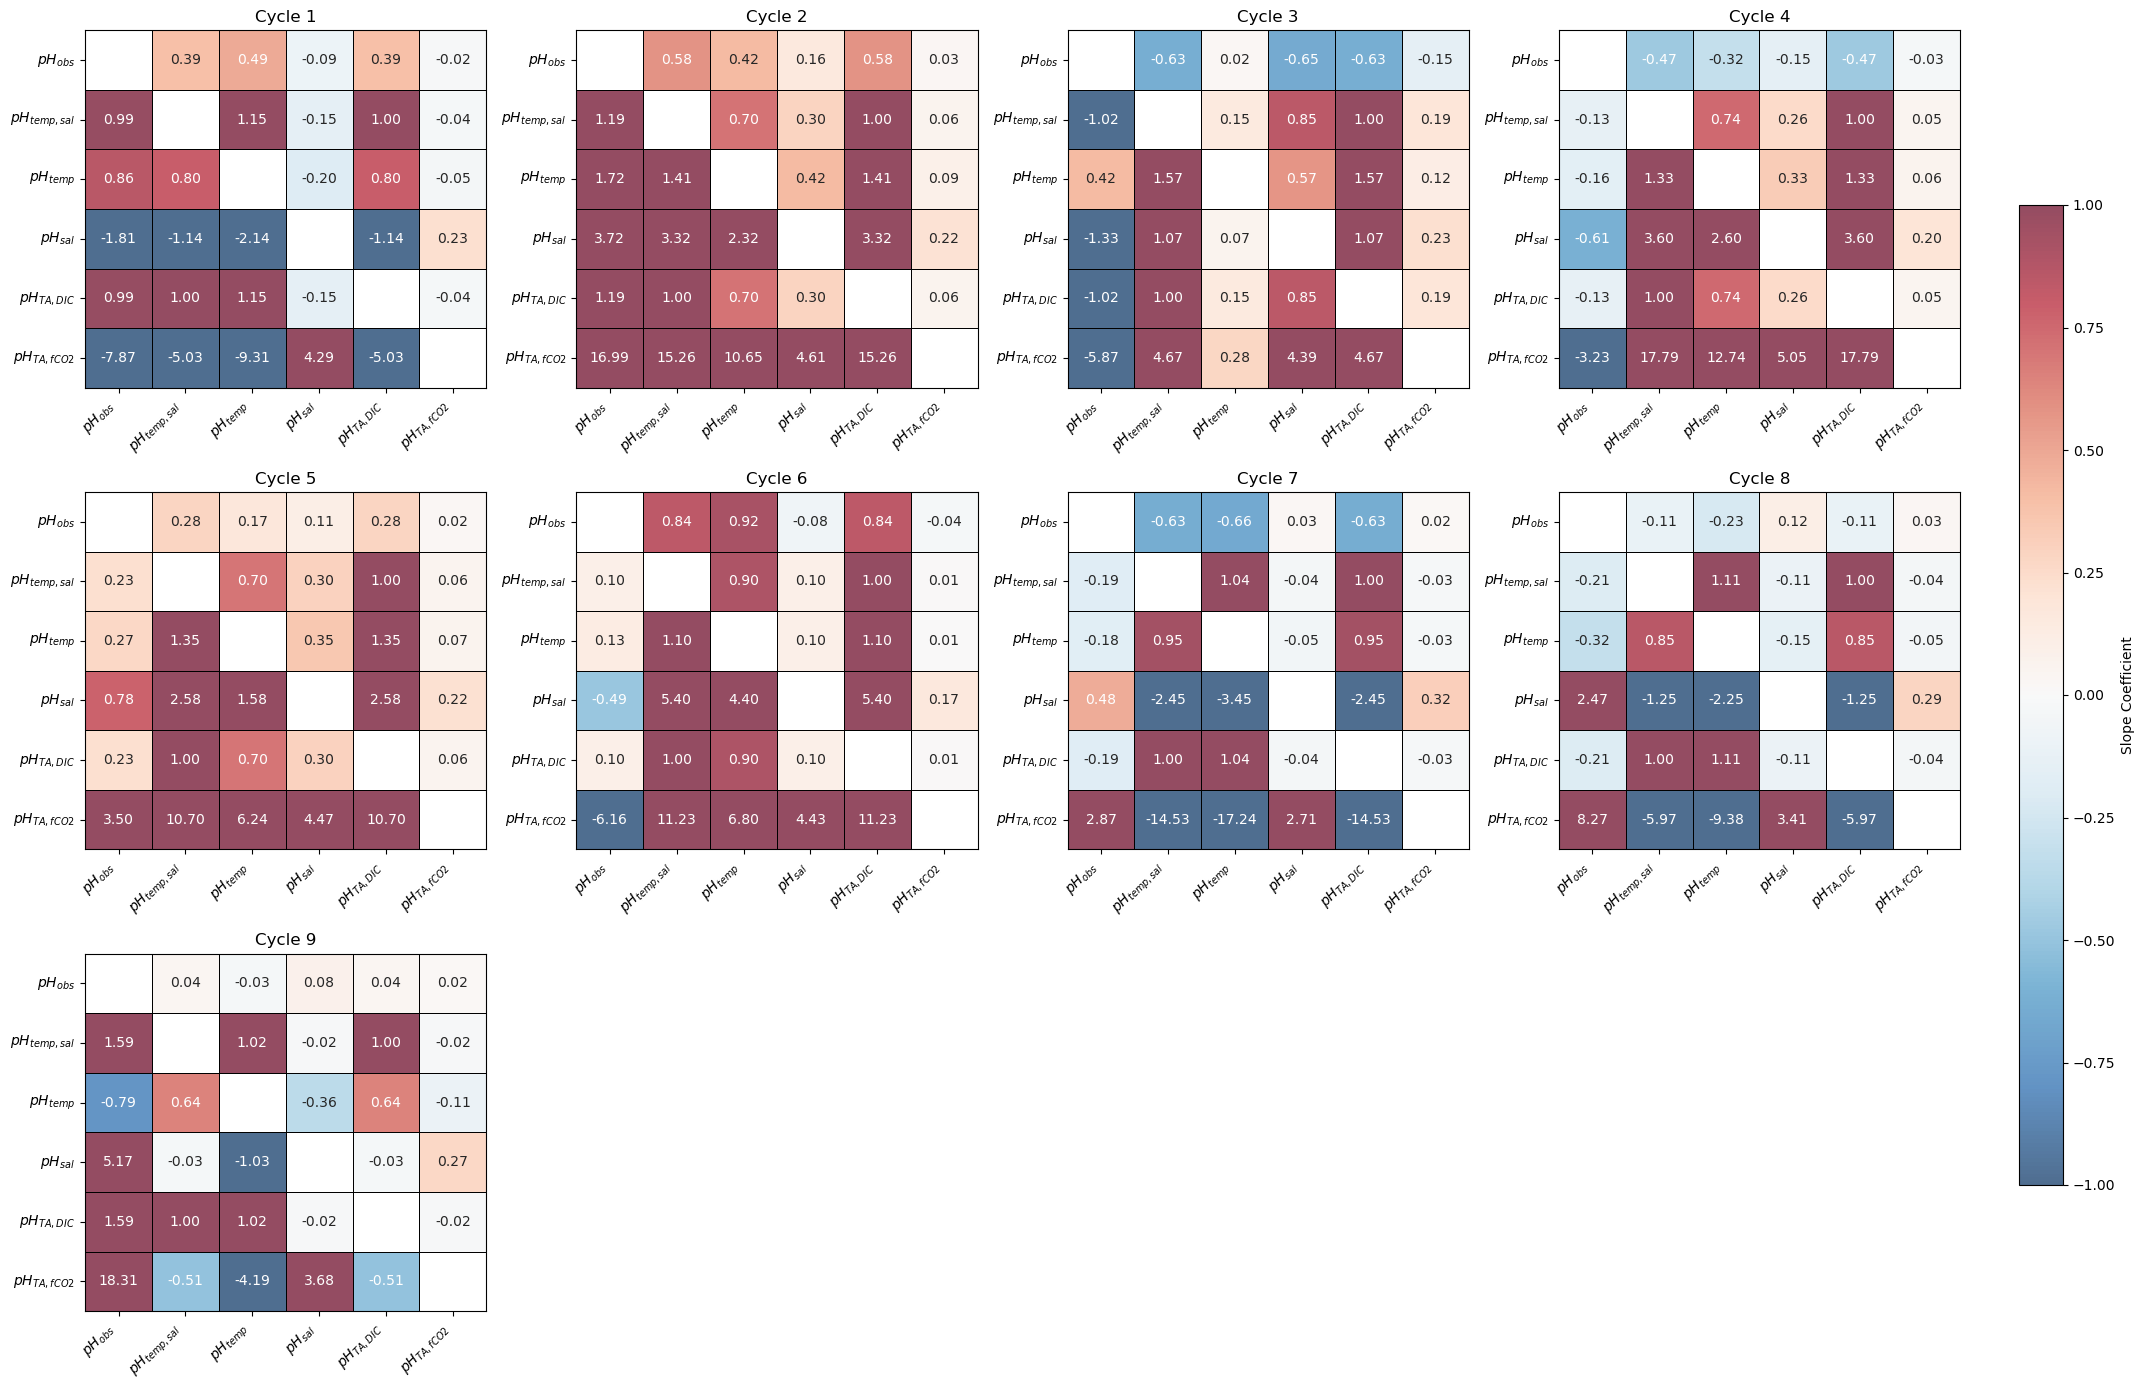

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Select the variables of interest for slope analysis
variables_of_interest = [
    'pH_TS_measured (optode)',    # pH measured (optode)
    'pH_temp_sal',                # pH calculated with temperature and salinity
    'pH_temp',                    # pH calculated with temperature fluctuation
    'pH_sal',                     # pH calculated with salinity fluctuation
    'pH_TA_DIC',                  # pH calculated with mean TA and mean DIC
    'pH_TA_fco2'                  # pH calculated with mean TA and mean fCO2
]

# Function to compute the slope matrix for a DataFrame
def compute_slope_matrix(df):
    slopes = pd.DataFrame(index=variables_of_interest, columns=variables_of_interest, dtype=float)
    for var1 in variables_of_interest:
        for var2 in variables_of_interest:
            if var1 != var2:
                # Drop NaN values before computing slope
                x = df[var1].values
                y = df[var2].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if np.sum(mask) > 1:  # Ensure there are enough points to fit a line
                    slope = np.polyfit(x[mask], y[mask], 1)[0]
                else:
                    slope = np.nan
                slopes.loc[var1, var2] = slope
            else:
                slopes.loc[var1, var2] = np.nan  # Diagonal elements set to NaN
    return slopes

# Function to create and display slope matrix heatmap for a list of DataFrames
def plot_slope_heatmaps(dfs):
    n_dfs = len(dfs)
    fig, axes = plt.subplots(3, 4, figsize=(22, 14))
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, df in enumerate(dfs):
        if i < 9:
            slope_matrix = compute_slope_matrix(df)
            mask = np.eye(len(slope_matrix), dtype=bool)  # Mask diagonal elements
            sns.heatmap(slope_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"],
                        yticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], mask=mask)
            axes[i].set_title(f"Cycle {i+1}")

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Hide the last two axes
    for ax in axes[9:]:
        ax.axis('off')

    # Show specific axis labels for clarity
    for ax in axes:
        if ax in axes[9:]:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.set_xticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=45, ha='right')
            ax.set_yticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=0)

    # Create a common color bar at the end
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Slope Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Plot the heatmaps for south_pacific_complete_cycles
plot_slope_heatmaps(south_pacific_complete_cycles[:11])

# Save the plot
plt.savefig(
    "figs/SO289_slope_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


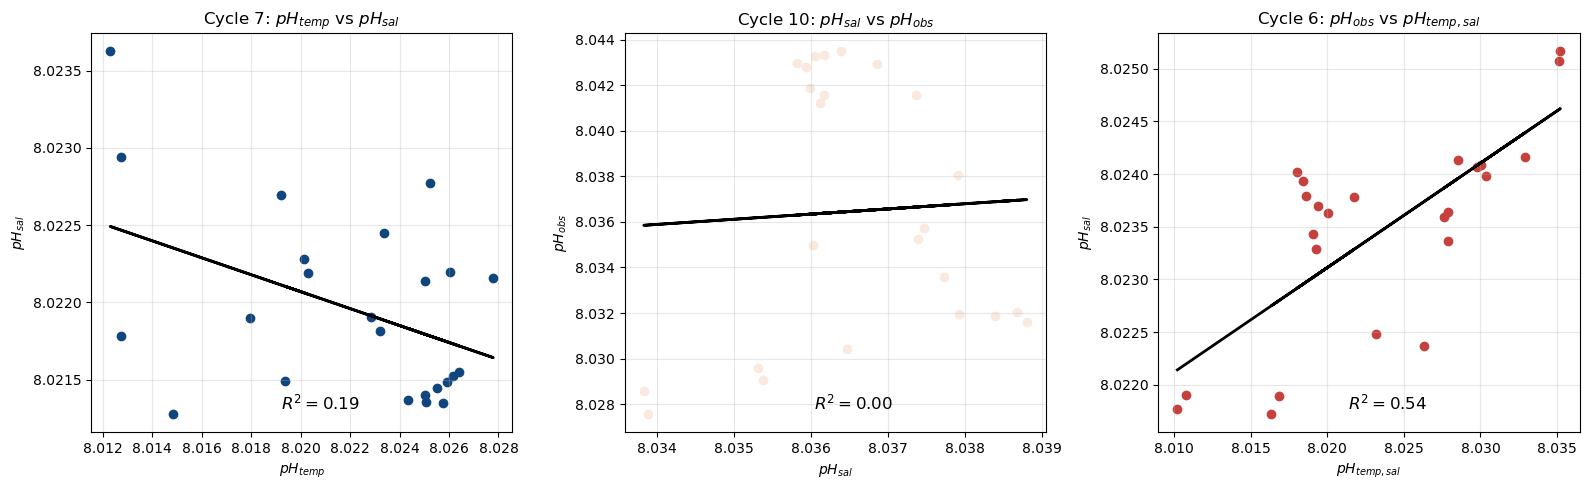

In [24]:
# Function to perform linear regression and plot results
def plot_linear_regression(ax, x, y, x_label, y_label, title, point_color):
    # Drop NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Perform linear regression
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))

    # Plot data points
    ax.scatter(x, y, color=point_color, label='Data points')
    
    # Plot regression line
    ax.plot(x, y_pred, color='k', linewidth=2, label='Regression line')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # Print R^2 score
    r2 = model.score(x.reshape(-1, 1), y)
    ax.text(0.45, 0.10, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')

# Initialize figure and axes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Get the RdBu colormap
rd_bu = plt.cm.get_cmap('RdBu', 256)

# Define colors for data points
color1 = rd_bu(245)  # Positive extreme
color2 = rd_bu(115)  # Middle
color3 = rd_bu(40)    # Negative extreme

# Subplot 1: Linear regression between pH_temp and pH_temp_sal for df 1
df1 = south_pacific_complete_cycles[6]
x = df1['pH_temp'].values
y = df1['pH_sal'].values
plot_linear_regression(axes[0], x, y, '$pH_{temp}$', '$pH_{sal}$', 'Cycle 7: $pH_{temp}$ vs $pH_{sal}$', color1)

# Subplot 2: Linear regression between pH_sal and pH_TS_measured (optode) for df 10
df10 = south_pacific_complete_cycles[9]
x = df10['pH_sal'].values
y = df10['pH_TS_measured (optode)'].values
plot_linear_regression(axes[1], x, y, '$pH_{sal}$', '$pH_{obs}$', 'Cycle 10: $pH_{sal}$ vs $pH_{obs}$', color2)

# Subplot 3: Linear regression between pH_TS_measured (optode) and pH_sal for df 6
df2 = south_pacific_complete_cycles[5]
x = df2['pH_temp_sal'].values
y = df2['pH_sal'].values
plot_linear_regression(axes[2], x, y, '$pH_{temp, sal}$', '$pH_{sal}$', 'Cycle 6: $pH_{obs}$ vs $pH_{temp, sal}$', color3)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO289_lin_regress_slope_corr_matrices.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


## Now comparing cycles

In [25]:
north_atlantic_complete_cycles[0].columns

Index(['Year_UTC', 'Month_UTC', 'Day_UTC', 'Latitude', 'Longitude', 'Depth',
       'Temperature', 'TEMP_pH', 'Salinity', 'Salinity_flag',
       'pH_TS_measured (optode)', 'pH_TS_measured (optode) uncertainty',
       'pH_flag', 'datenum', 'talk', 'tco2', 'tco2_unc', 'fco2', 'fco2_unc',
       'smb_chl', 'wind_speed', 'smb_tur', 'SLA', 'thetao', 'Longitude_mean',
       'time_offset', 'pH_temp_sal', 'pH_temp', 'pH_sal', 'pH_TA_DIC',
       'pH_TA_fco2', 'pH_cycle_mean', 'pH_global'],
      dtype='object')

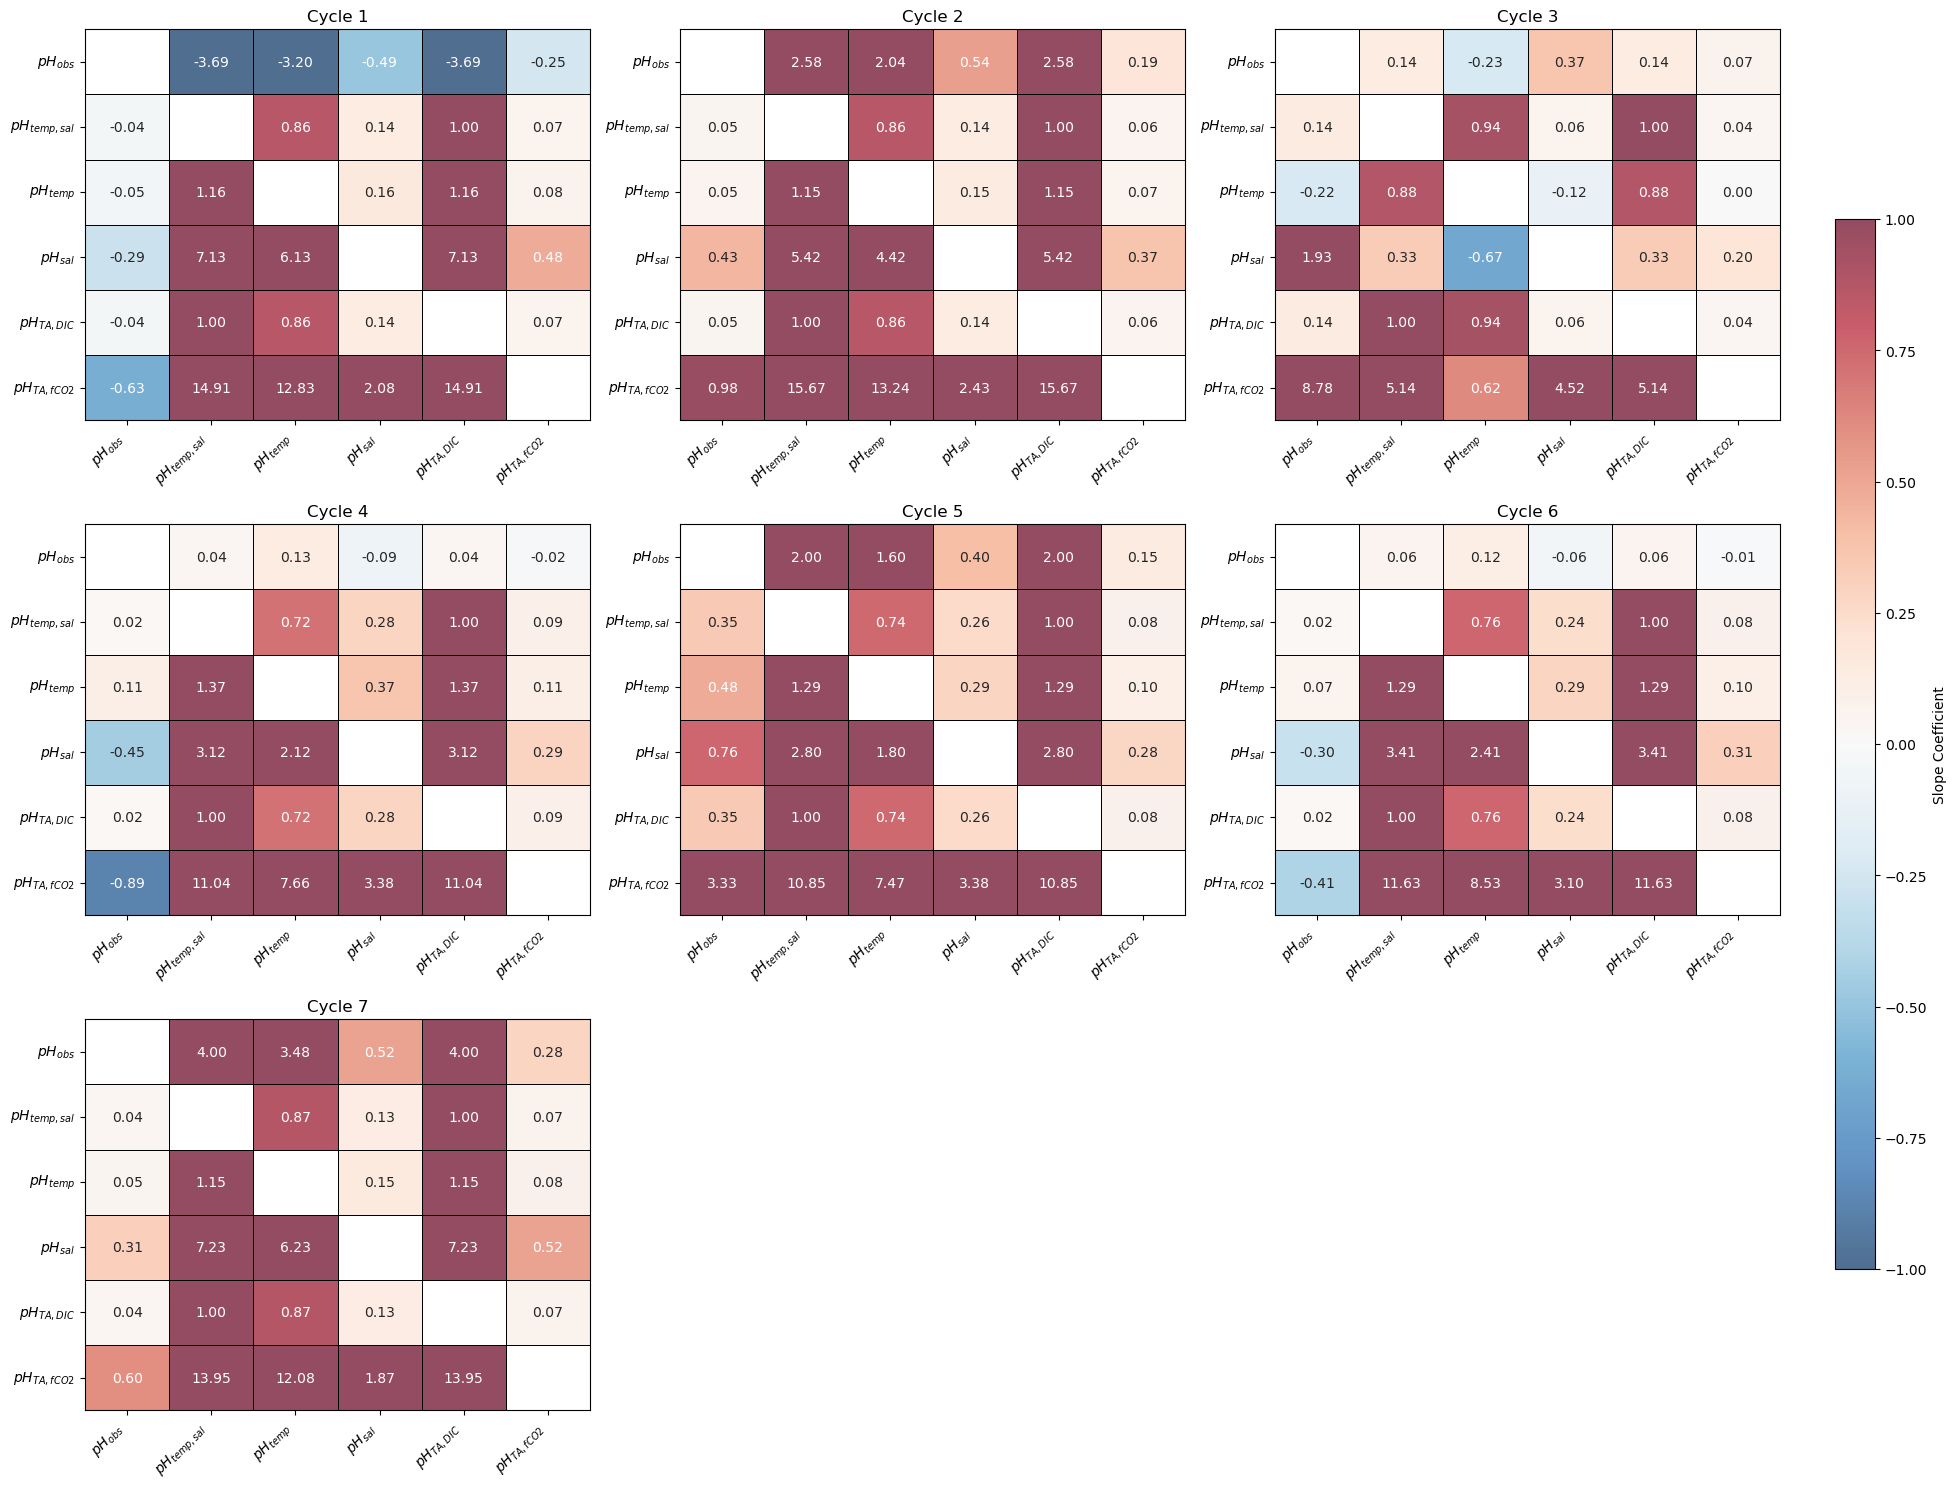

<Figure size 640x480 with 0 Axes>

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Select the variables of interest for slope analysis
variables_of_interest = [
    'pH_TS_measured (optode)',    # pH measured (optode)
    'pH_temp_sal',                # pH calculated with temperature and salinity
    'pH_temp',                    # pH calculated with temperature fluctuation
    'pH_sal',                     # pH calculated with salinity fluctuation
    'pH_TA_DIC',                  # pH calculated with mean TA and mean DIC
    'pH_TA_fco2'                  # pH calculated with mean TA and mean fCO2
]

# Function to compute the slope matrix for a DataFrame
def compute_slope_matrix(df):
    slopes = pd.DataFrame(index=variables_of_interest, columns=variables_of_interest, dtype=float)
    for var1 in variables_of_interest:
        for var2 in variables_of_interest:
            if var1 != var2:
                # Drop NaN values before computing slope
                x = df[var1].values
                y = df[var2].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if np.sum(mask) > 1:  # Ensure there are enough points to fit a line
                    slope = np.polyfit(x[mask], y[mask], 1)[0]
                else:
                    slope = np.nan
                slopes.loc[var1, var2] = slope
            else:
                slopes.loc[var1, var2] = np.nan  # Diagonal elements set to NaN
    return slopes

# Function to create and display slope matrix heatmap for a list of DataFrames
def plot_slope_heatmaps(dfs):
    n_dfs = len(dfs)
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # Adjusted figure size for better visibility
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, df in enumerate(dfs):
        if i < 7:
            slope_matrix = compute_slope_matrix(df)
            mask = np.eye(len(slope_matrix), dtype=bool)  # Mask diagonal elements
            sns.heatmap(slope_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"],
                        yticklabels=["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], mask=mask)
            axes[i].set_title(f"Cycle {i+1}")

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Hide the last two axes
    for ax in axes[7:]:
        ax.axis('off')

    # Show specific axis labels for clarity
    for ax in axes:
        ax.set_xticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=45, ha='right')
        ax.set_yticklabels(["$pH_{obs}$", "$pH_{temp, sal}$", "$pH_{temp}$", "$pH_{sal}$", "$pH_{TA, DIC}$", "$pH_{TA, fCO2}$"], rotation=0)

    # Create a common color bar at the end
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Slope Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Plot the heatmaps for north_atlantic_complete_cycles
plot_slope_heatmaps(north_atlantic_complete_cycles[:7])

# Save the plot
plt.savefig(
    "figs/SO279_slope_matrices_cycles_compared.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


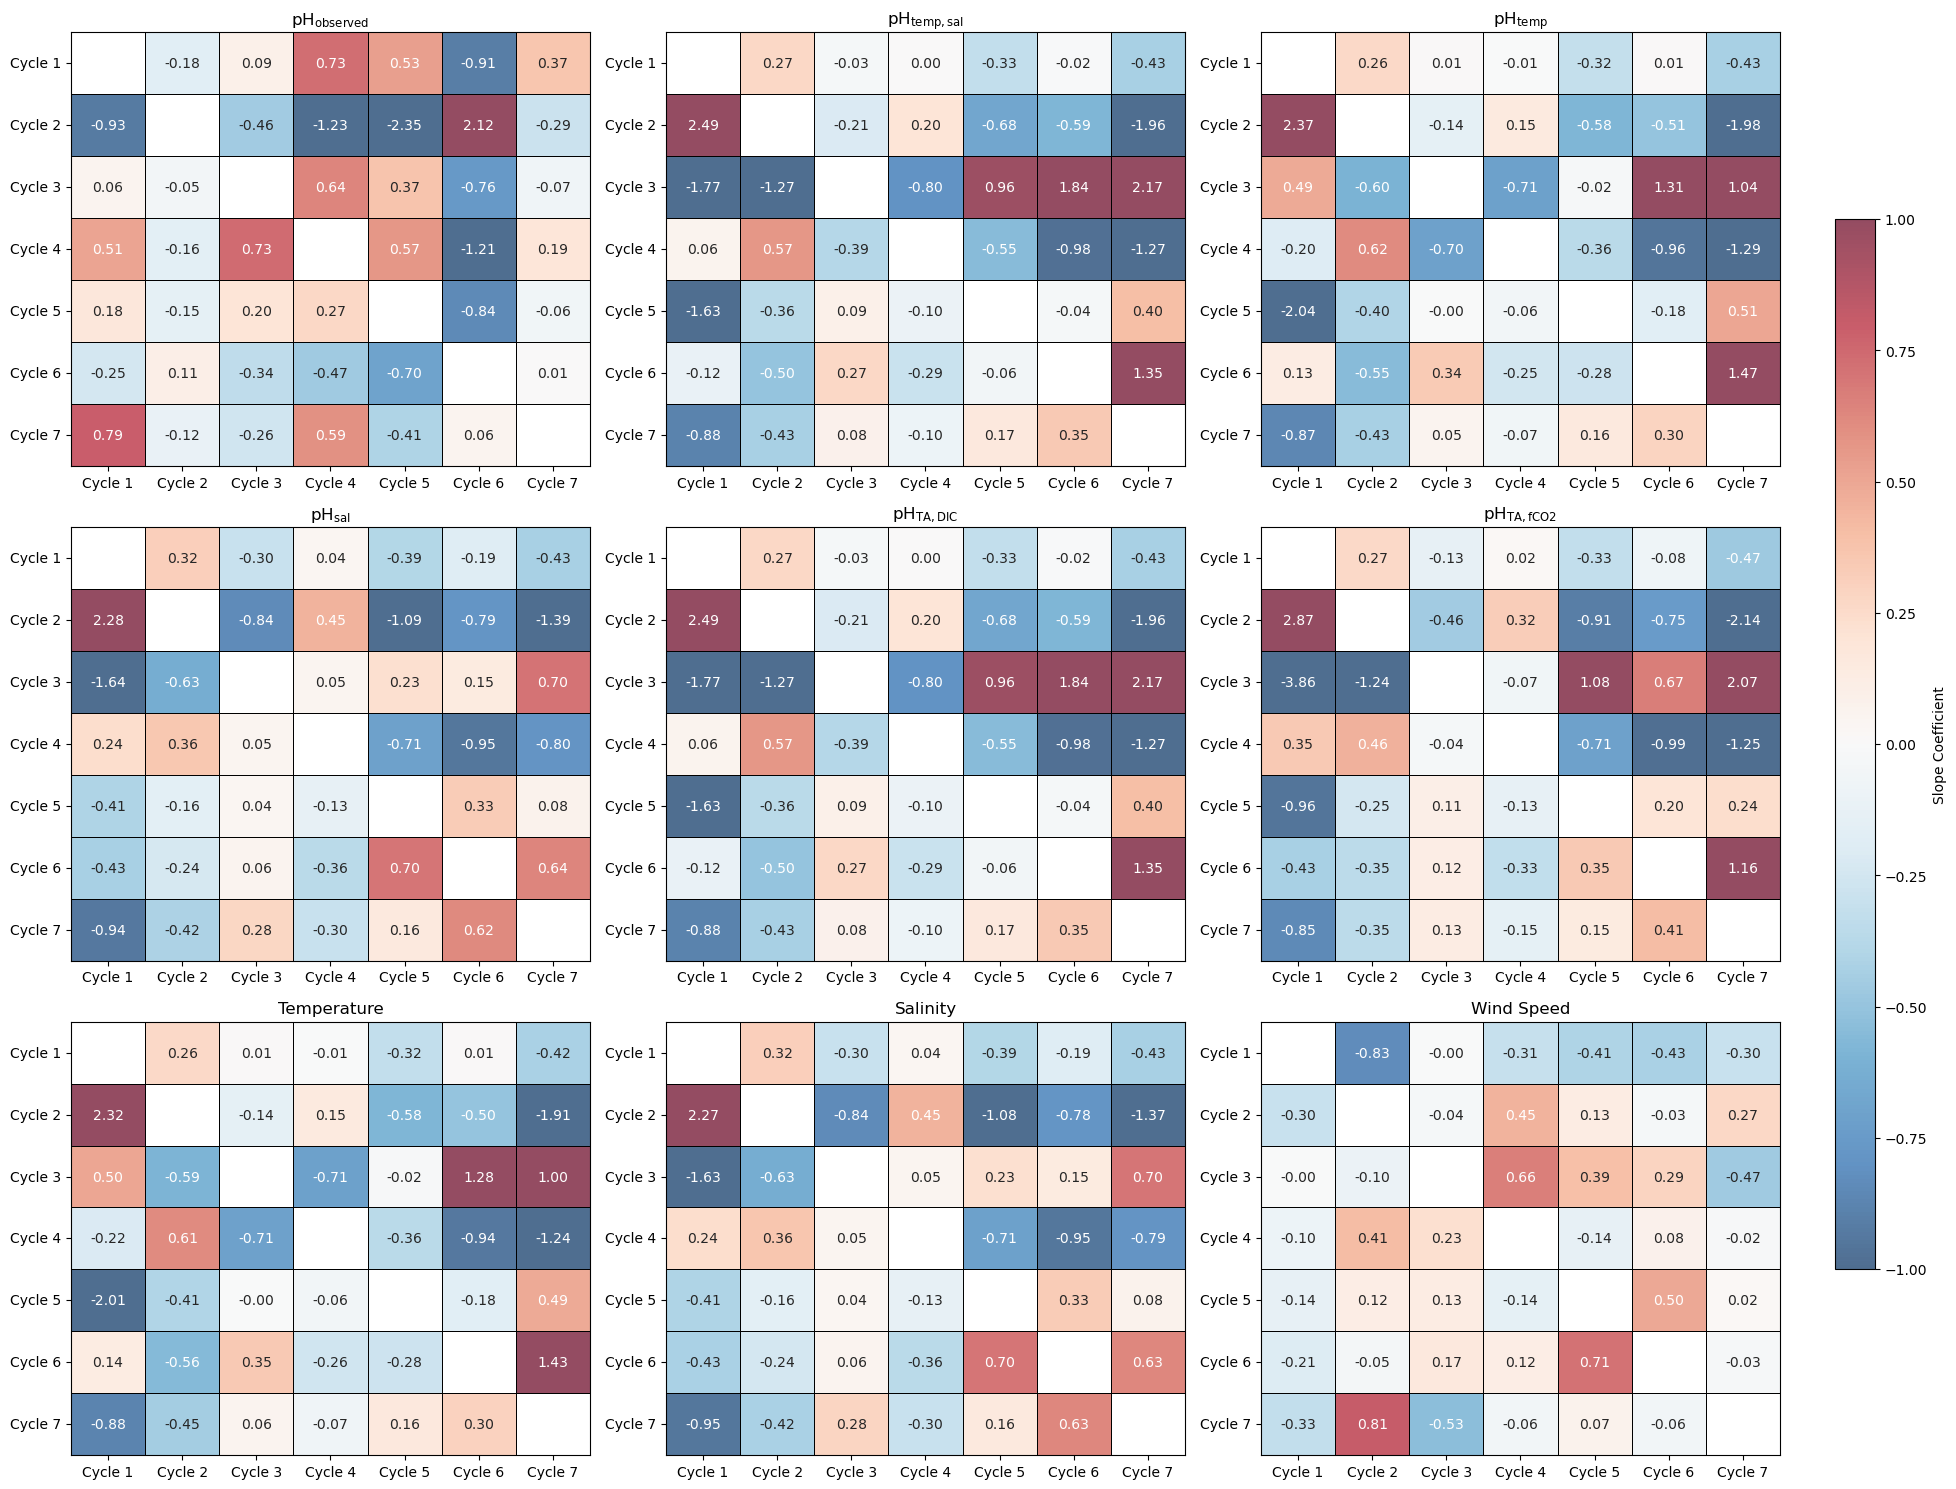

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the variables to compare for each cycle
variables_to_compare = [
    'pH_TS_measured (optode)', 'pH_temp_sal', 'pH_temp', 'pH_sal', 'pH_TA_DIC', 'pH_TA_fco2',
    'Temperature', 'Salinity', 'wind_speed',
]

# Define custom titles for each subplot
custom_titles = [
    r'$\mathrm{pH_{observed}}$', r'$\mathrm{pH_{temp, sal}}$', r'$\mathrm{pH_{temp}}$', r'$\mathrm{pH_{sal}}$', 
    r'$\mathrm{pH_{TA, DIC}}$', r'$\mathrm{pH_{TA, fCO2}}$', 'Temperature', 'Salinity', 'Wind Speed'
]

# Function to compute the slope matrix for a DataFrame
def compute_slope_matrix(df, cycles):
    slopes = pd.DataFrame(index=cycles, columns=cycles, dtype=float)
    for cycle1 in cycles:
        for cycle2 in cycles:
            if cycle1 != cycle2:
                x = df[cycle1].values
                y = df[cycle2].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if np.sum(mask) > 1:  # Ensure there are enough points to fit a line
                    slope = np.polyfit(x[mask], y[mask], 1)[0]
                else:
                    slope = np.nan
                slopes.loc[cycle1, cycle2] = slope
            else:
                slopes.loc[cycle1, cycle2] = np.nan  # Diagonal elements set to NaN
    return slopes

# Function to create and display slope matrix heatmap for each variable
def plot_variable_slope_heatmaps(dfs, cycles):
    n_vars = len(variables_to_compare)
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # Adjusted figure size for better visibility
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, var in enumerate(variables_to_compare):
        if i < len(axes):
            df_var = pd.DataFrame({f'Cycle {j+1}': dfs[j][var] for j in range(len(dfs))})
            slope_matrix = compute_slope_matrix(df_var, [f'Cycle {j+1}' for j in range(len(dfs))])
            mask = np.eye(len(slope_matrix), dtype=bool)  # Mask diagonal elements
            sns.heatmap(slope_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=[f'Cycle {j+1}' for j in range(len(dfs))],
                        yticklabels=[f'Cycle {j+1}' for j in range(len(dfs))], mask=mask)
            axes[i].set_title(custom_titles[i])

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Create a common color bar in the 9th subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Slope Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Plot the heatmaps for each variable comparing cycles
plot_variable_slope_heatmaps(north_atlantic_complete_cycles[:9], [f'Cycle {i+1}' for i in range(9)])

# Save the plot
# plt.savefig(
#     "figs/SO279_slope_matrices_variables_compared.png",
#     dpi=300,
#     bbox_inches="tight",
#     pad_inches=0.1,
# )


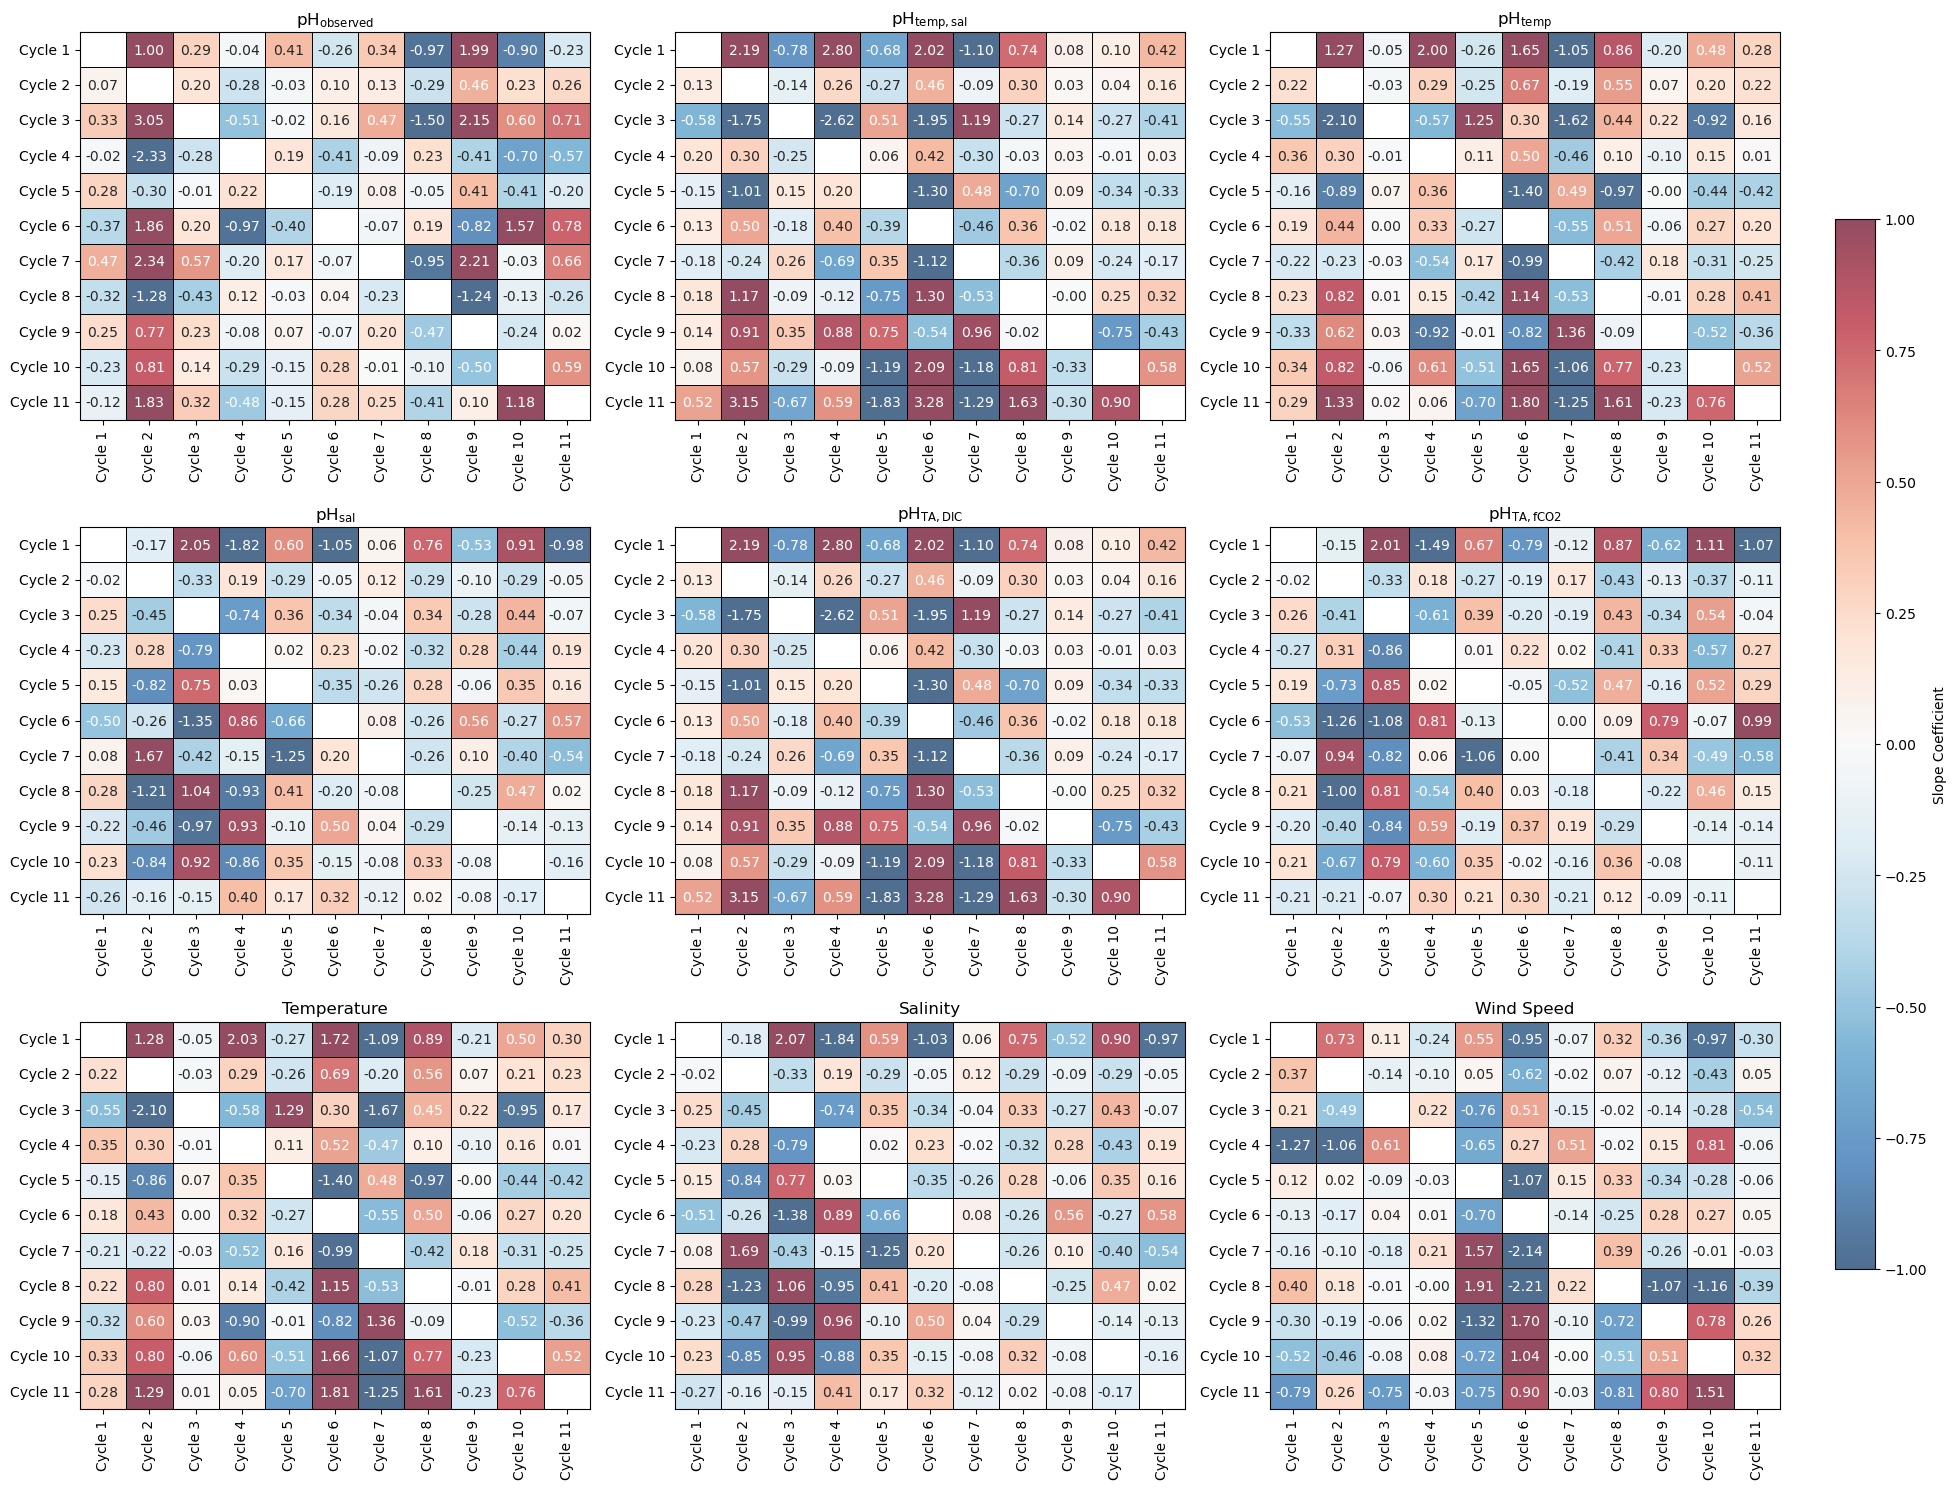

<Figure size 640x480 with 0 Axes>

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the variables to compare for each cycle
variables_to_compare = [
    'pH_TS_measured (optode)', 'pH_temp_sal', 'pH_temp', 'pH_sal', 'pH_TA_DIC', 'pH_TA_fco2',
    'Temperature', 'Salinity', 'wind_speed',
]

# Define custom titles for each subplot
custom_titles = [
    r'$\mathrm{pH_{observed}}$', r'$\mathrm{pH_{temp, sal}}$', r'$\mathrm{pH_{temp}}$', r'$\mathrm{pH_{sal}}$', 
    r'$\mathrm{pH_{TA, DIC}}$', r'$\mathrm{pH_{TA, fCO2}}$', 'Temperature', 'Salinity', 'Wind Speed'
]

# Function to compute the slope matrix for a DataFrame
def compute_slope_matrix(df, cycles):
    slopes = pd.DataFrame(index=cycles, columns=cycles, dtype=float)
    for cycle1 in cycles:
        for cycle2 in cycles:
            if cycle1 != cycle2:
                x = df[cycle1].values
                y = df[cycle2].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if np.sum(mask) > 1:  # Ensure there are enough points to fit a line
                    slope = np.polyfit(x[mask], y[mask], 1)[0]
                else:
                    slope = np.nan
                slopes.loc[cycle1, cycle2] = slope
            else:
                slopes.loc[cycle1, cycle2] = np.nan  # Diagonal elements set to NaN
    return slopes

# Function to create and display slope matrix heatmap for each variable
def plot_variable_slope_heatmaps(dfs, cycles):
    n_vars = len(variables_to_compare)
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # Adjusted figure size for better visibility
    axes = axes.flatten()
    
    # Create a custom colormap with alpha = 0.7
    colors = sns.color_palette("RdBu_r", as_cmap=True)(np.linspace(0, 1, 256))
    colors[:, -1] = 0.7
    cmap = mcolors.LinearSegmentedColormap.from_list("RdBu_alpha", colors)

    for i, var in enumerate(variables_to_compare):
        if i < len(axes):
            df_var = pd.DataFrame({f'Cycle {j+1}': dfs[j][var] for j in range(len(dfs))})
            slope_matrix = compute_slope_matrix(df_var, [f'Cycle {j+1}' for j in range(len(dfs))])
            mask = np.eye(len(slope_matrix), dtype=bool)  # Mask diagonal elements
            sns.heatmap(slope_matrix, ax=axes[i], annot=True, cmap=cmap,
                        vmin=-1, vmax=1, linewidths=0.5, linecolor="black", fmt=".2f", cbar=False,
                        xticklabels=[f'Cycle {j+1}' for j in range(len(dfs))],
                        yticklabels=[f'Cycle {j+1}' for j in range(len(dfs))], mask=mask)
            axes[i].set_title(custom_titles[i])

            # Draw border
            for _, spine in axes[i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.8)
    
    # Create a common color bar in the 9th subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Slope Coefficient')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Plot the heatmaps for each variable comparing cycles
plot_variable_slope_heatmaps(south_pacific_complete_cycles[:11], [f'Cycle {i+1}' for i in range(11)])

# Save the plot
plt.savefig(
    "figs/SO289_slope_matrices_variables_compared.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


### T/S diagrams

### Latitude

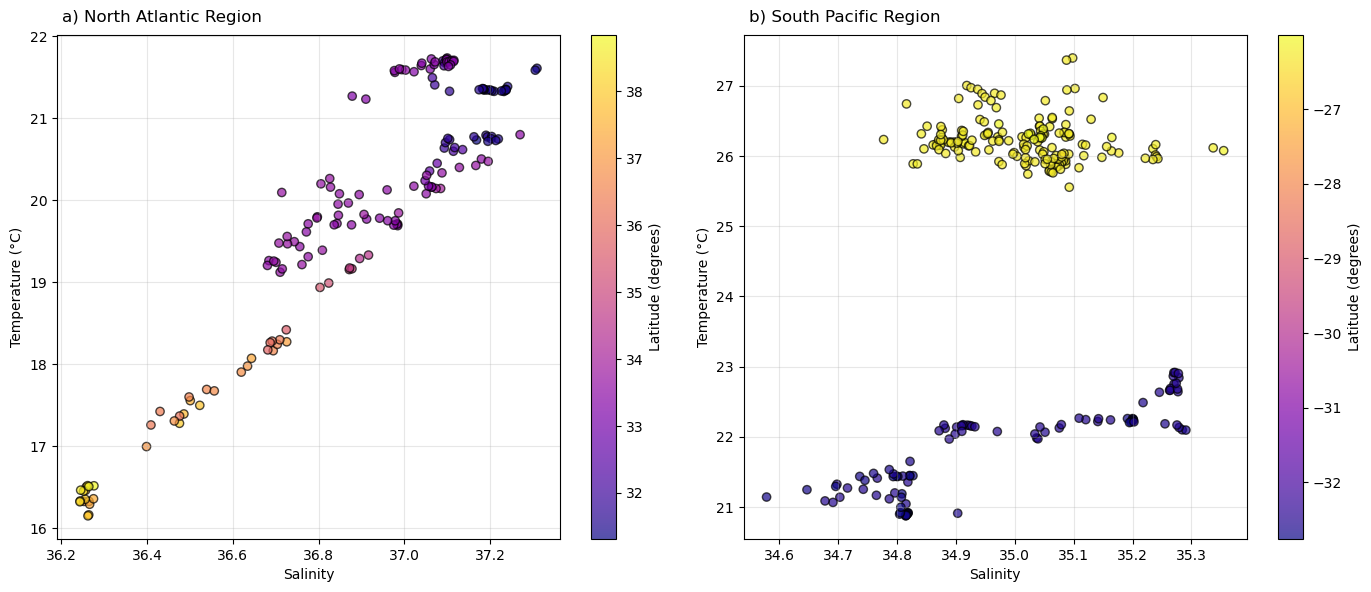

In [29]:
# Function to plot salinity vs. temperature with pH as colorbar
def plot_sal_temp_with_pH(ax, df):
    # Drop NaN values
    df = df.dropna(subset=['Temperature', 'Salinity', 'Latitude'])
    
    # Scatter plot
    sc = ax.scatter(df['Salinity'], df['Temperature'], c=df['Latitude'], cmap='plasma', alpha=0.7, edgecolor='k')
    
    # Set labels and title
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature (°C)')
#     ax.set_title(title)
    ax.grid(alpha=0.3)
    
    return sc

# Combine all data from each cycle into a single DataFrame for each basin
north_atlantic_data = pd.concat(north_atlantic_complete_cycles, ignore_index=True)
south_pacific_data = pd.concat(south_pacific_complete_cycles, ignore_index=True)

# Initialize figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: North Atlantic
sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data)
axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Subplot 2: South Pacific
sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data)
axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Add color bars
cbar1 = plt.colorbar(sc1, ax=axes[0], orientation='vertical')
cbar1.set_label('Latitude (degrees)')

cbar2 = plt.colorbar(sc2, ax=axes[1], orientation='vertical')
cbar2.set_label('Latitude (degrees)')

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO279_SO289_TS_lat.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()


### pH

In [30]:
# # Function to plot salinity vs. temperature with pH as colorbar
# def plot_sal_temp_with_pH(ax, df):
#     # Drop NaN values
#     df = df.dropna(subset=['Temperature', 'Salinity', 'pH_TS_measured (optode)'])
    
#     # Scatter plot
#     sc = ax.scatter(df['Salinity'], df['Temperature'], c=df['pH_TS_measured (optode)'], cmap='plasma', alpha=0.7, edgecolor='k')
    
#     # Set labels and title
#     ax.set_xlabel('Salinity')
#     ax.set_ylabel('Temperature')
# #     ax.set_title(title)
#     ax.grid(alpha=0.3)
    
#     return sc

# # Combine all data from each cycle into a single DataFrame for each basin
# north_atlantic_data = pd.concat(north_atlantic_complete_cycles, ignore_index=True)
# south_pacific_data = pd.concat(south_pacific_complete_cycles, ignore_index=True)

# # Initialize figure and axes
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Subplot 1: North Atlantic
# sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data)
# axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# # Subplot 2: South Pacific
# sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data)
# axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# # Add color bars
# cbar1 = plt.colorbar(sc1, ax=axes[0], orientation='vertical')
# cbar1.set_label('Observed pH')

# cbar2 = plt.colorbar(sc2, ax=axes[1], orientation='vertical')
# cbar2.set_label('Observed pH')

# # Adjust layout and show plot
# plt.tight_layout()

# # Save the plot
# plt.savefig(
#     "figs/SO279_SO289_TS_pH.png",
#     dpi=300,
#     bbox_inches="tight",
#     pad_inches=0.1,
# )

# plt.show()



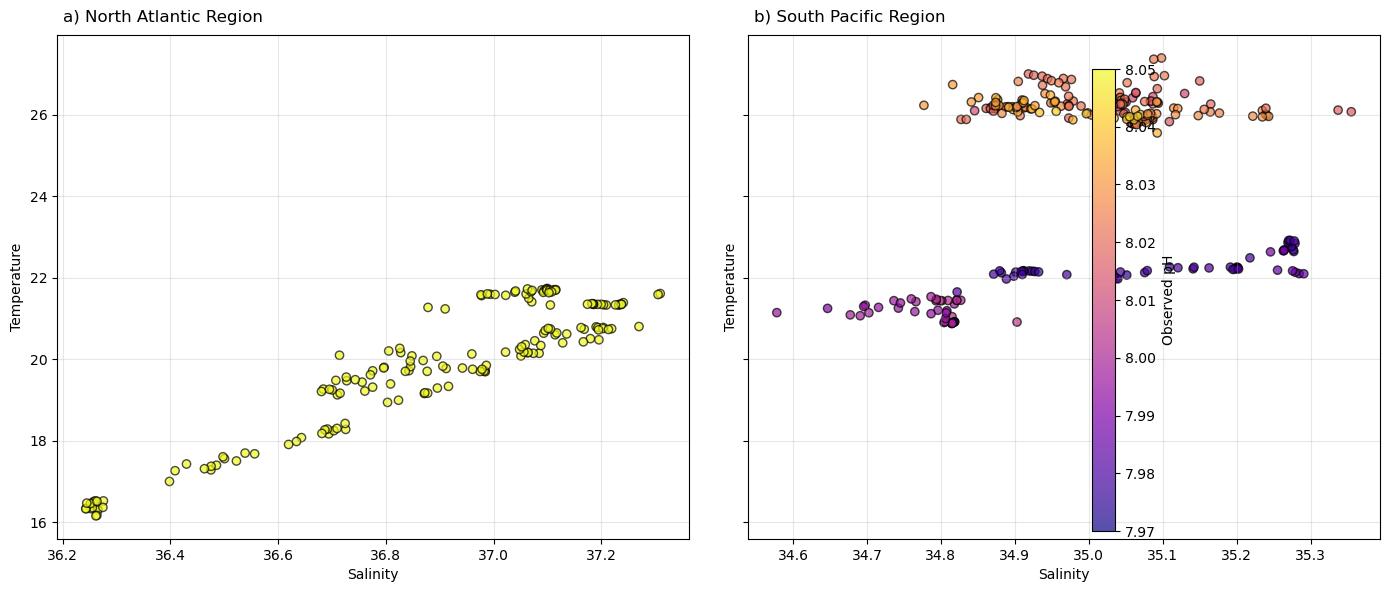

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sal_temp_with_pH(ax, df, vmin, vmax):
    # Drop NaN values
    df = df.dropna(subset=['Temperature', 'Salinity', 'pH_TS_measured (optode)'])
    
    # Scatter plot with specified vmin and vmax for consistent coloring across plots
    sc = ax.scatter(df['Salinity'], df['Temperature'], 
                    c=df['pH_TS_measured (optode)'], cmap='plasma', 
                    alpha=0.7, edgecolor='k', vmin=vmin, vmax=vmax)
    
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature')
    ax.grid(alpha=0.3)
    
    return sc

# Assuming your data is already loaded in north_atlantic_data and south_pacific_data
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define pH range
pH_min, pH_max = 7.97, 8.05

# Subplot 1: North Atlantic
sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data, pH_min, pH_max)
axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Subplot 2: South Pacific
sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data, pH_min, pH_max)
axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Common colorbar for both subplots
cbar = fig.colorbar(sc1, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Observed pH')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("figs/SO279_SO289_TS_pH.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


In [32]:
import pandas as pd

# Iterate through each DataFrame in the list
import pandas as pd

# Iterate through each DataFrame in the list
for df in north_atlantic_complete_cycles:
    # Ensure Year_UTC, Month_UTC, and Day_UTC are integers to avoid any decimal issues
    df['Year_UTC'] = df['Year_UTC'].astype(int)
    df['Month_UTC'] = df['Month_UTC'].astype(int)
    df['Day_UTC'] = df['Day_UTC'].astype(int)

    # Create datetime column from year, month, and day
    df['datetime'] = pd.to_datetime({
        'year': df['Year_UTC'],
        'month': df['Month_UTC'],
        'day': df['Day_UTC']
    })

    # Convert datetime to a numeric date format, such as ordinal
    df['datenum'] = df['datetime'].apply(lambda x: x.toordinal())

# At this point, each DataFrame in the list has the new 'datetime' and 'datenum' columns

import pandas as pd

# Iterate through each DataFrame in the list
for df in south_pacific_complete_cycles:
    # Ensure Year_UTC, Month_UTC, and Day_UTC are integers to avoid any decimal issues
    df['Year_UTC'] = df['Year_UTC'].astype(int)
    df['Month_UTC'] = df['Month_UTC'].astype(int)
    df['Day_UTC'] = df['Day_UTC'].astype(int)

    # Create datetime column from year, month, and day
    df['datetime'] = pd.to_datetime({
        'year': df['Year_UTC'],
        'month': df['Month_UTC'],
        'day': df['Day_UTC']
    })

    # Convert datetime to a numeric date format, such as ordinal
    df['datenum'] = df['datetime'].apply(lambda x: x.toordinal())

# At this point, each DataFrame in the list has the new 'datetime' and 'datenum' columns


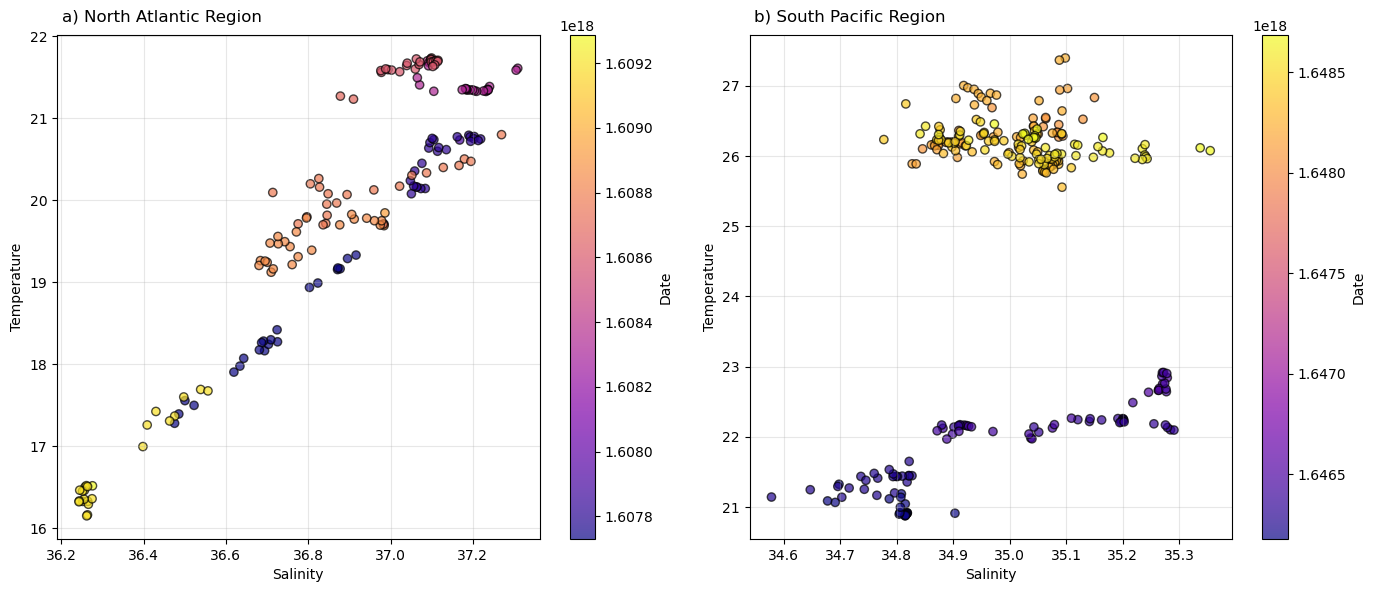

In [33]:
# Function to plot salinity vs. temperature with pH as colorbar
def plot_sal_temp_with_pH(ax, df):
    # Drop NaN values
    df = df.dropna(subset=['Temperature', 'Salinity', 'pH_TS_measured (optode)'])
    
    # Scatter plot
    sc = ax.scatter(df['Salinity'], df['Temperature'], c=df['datetime'], cmap='plasma', alpha=0.7, edgecolor='k')
    
    # Set labels and title
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature')
#     ax.set_title(title)
    ax.grid(alpha=0.3)
    
    return sc

# Combine all data from each cycle into a single DataFrame for each basin
north_atlantic_data = pd.concat(north_atlantic_complete_cycles, ignore_index=True)
south_pacific_data = pd.concat(south_pacific_complete_cycles, ignore_index=True)

# Initialize figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: North Atlantic
sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data)
axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Subplot 2: South Pacific
sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data)
axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Add color bars
cbar1 = plt.colorbar(sc1, ax=axes[0], orientation='vertical')
cbar1.set_label('Date')

cbar2 = plt.colorbar(sc2, ax=axes[1], orientation='vertical')
cbar2.set_label('Date')

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO279_SO289_TS_date.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()



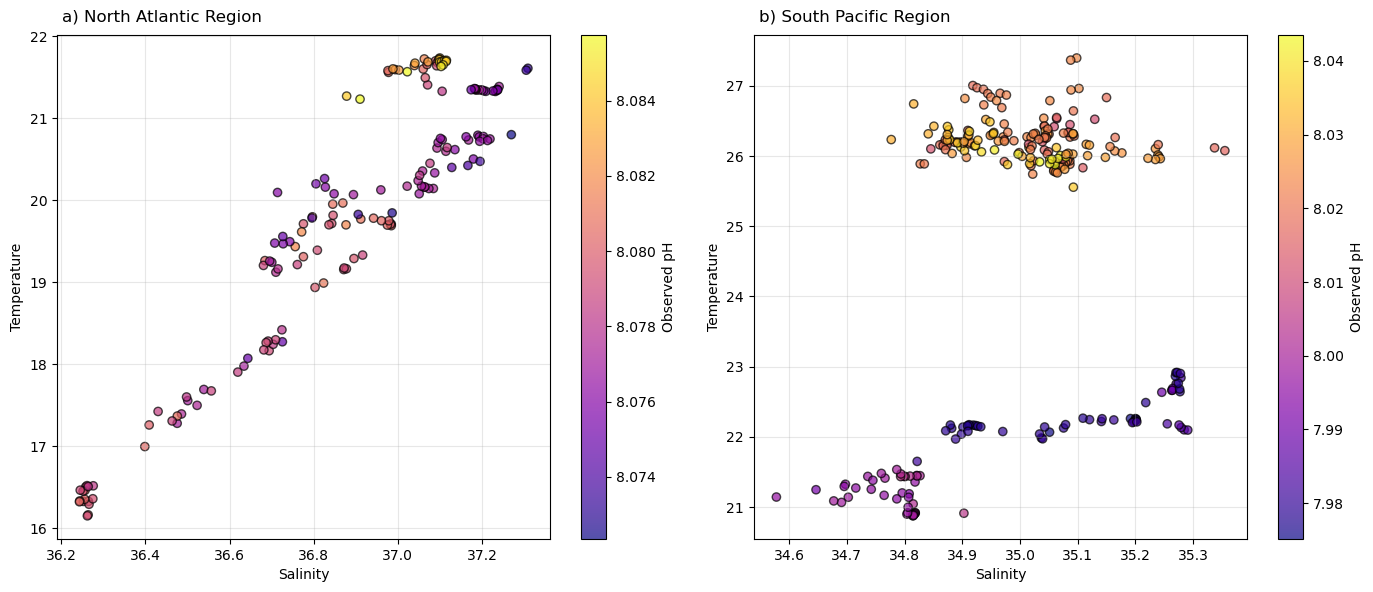

In [34]:
# Function to plot salinity vs. temperature with pH as colorbar
def plot_sal_temp_with_pH(ax, df):
    # Drop NaN values
    df = df.dropna(subset=['Temperature', 'Salinity', 'pH_TS_measured (optode)'])
    
    # Scatter plot
    sc = ax.scatter(df['Salinity'], df['Temperature'], c=df['pH_TS_measured (optode)'], cmap='plasma', alpha=0.7, edgecolor='k')
    
    # Set labels and title
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature')
#     ax.set_title(title)
    ax.grid(alpha=0.3)
    
    return sc

# Combine all data from each cycle into a single DataFrame for each basin
north_atlantic_data = pd.concat(north_atlantic_complete_cycles, ignore_index=True)
south_pacific_data = pd.concat(south_pacific_complete_cycles, ignore_index=True)

# Initialize figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: North Atlantic
sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data)
axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Subplot 2: South Pacific
sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data)
axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Add color bars
cbar1 = plt.colorbar(sc1, ax=axes[0], orientation='vertical')
cbar1.set_label('Observed pH')

cbar2 = plt.colorbar(sc2, ax=axes[1], orientation='vertical')
cbar2.set_label('Observed pH')

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/SO279_SO289_TS_pdatepng",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()



## Look at residuals

### North Atlantic Region

Cycle 1 - residuals_temp_sal: min=-0.023385209008051078, max=0.028481730118128823, mean=-0.0002835364193423118
Cycle 1 - residuals_temp: min=-0.02027781131255324, max=0.024336672511056534, mean=-0.00027737351406798005
Cycle 1 - residuals_sal: min=-0.0046671513334359815, max=0.0036125266084212626, mean=-0.00023405583535004068
Cycle 1 - residuals_TA_DIC: min=-0.023385209008051078, max=0.028481730118128823, mean=-0.0002835364193423118
Cycle 1 - residuals_TA_fCO2: min=-0.005217377153346803, max=0.001992777759317832, mean=-0.0013674829979202219
Cycle 2 - residuals_temp_sal: min=-0.008501375233613828, max=0.0038244083609804136, mean=-0.00012117421843438336
Cycle 2 - residuals_temp: min=-0.007619251612791089, max=0.0029772945788764105, mean=-0.00012043262517817215
Cycle 2 - residuals_sal: min=-0.0012758397370813412, max=0.0012555850871045493, mean=-0.0001158508798599911
Cycle 2 - residuals_TA_DIC: min=-0.008501375233613828, max=0.0038244083609804136, mean=-0.00012117421843438336
Cycle 2 - res

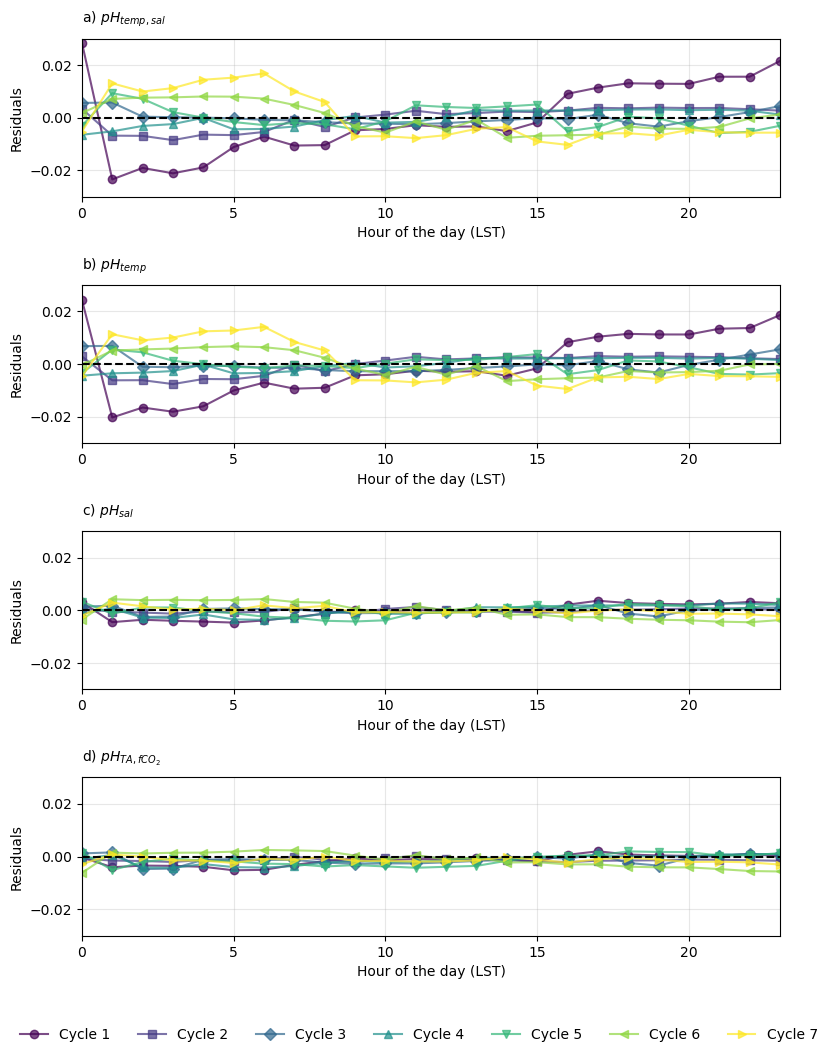

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate residuals and print statistics
def calculate_residuals(df, cycle_num):
    df['residuals_temp_sal'] = df['pH_TS_measured (optode)'] - df['pH_temp_sal']
    df['residuals_temp'] = df['pH_TS_measured (optode)'] - df['pH_temp']
    df['residuals_sal'] = df['pH_TS_measured (optode)'] - df['pH_sal']
    df['residuals_TA_DIC'] = df['pH_TS_measured (optode)'] - df['pH_TA_DIC']
    df['residuals_TA_fCO2'] = df['pH_TS_measured (optode)'] - df['pH_TA_fco2']
    
    # Print min, max, and mean residuals for each column
    residuals_cols = ['residuals_temp_sal', 'residuals_temp', 'residuals_sal', 'residuals_TA_DIC', 'residuals_TA_fCO2']
    for col in residuals_cols:
        print(f"Cycle {cycle_num} - {col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean()}")
    
    return df

# Apply the residuals calculation to each DataFrame in north_atlantic_complete_cycles
north_atlantic_residuals = [calculate_residuals(df.copy(), i+1) for i, df in enumerate(north_atlantic_complete_cycles)]

# Define markers and colors for each cycle
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']
colors = plt.cm.viridis(np.linspace(0, 1, len(north_atlantic_residuals)))

# Function to plot residuals with different colors and markers for each DataFrame
def plot_residuals(ax, dfs, column, label, colors, markers):
    for i, df in enumerate(dfs):
        ax.plot(df.index, df[column], marker=markers[i % len(markers)], color=colors[i], alpha=0.7, linestyle='-', label=f'Cycle {i+1}')
    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('Residuals')
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 23)
    ax.set_ylim(-0.03, 0.03)  # Set y-axis limits
    ax.axhline(0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
    ax.text(0, 1.1, label, transform=ax.transAxes)

# Initialize figure and axes
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

# Subplot labels
subplot_labels = ['a) $pH_{temp,sal}$', 'b) $pH_{temp}$', 'c) $pH_{sal}$', 'd) $pH_{TA, fCO_{2}}$']

# Subplot 1: Residuals for pH_temp_sal
plot_residuals(axes[0], north_atlantic_residuals, 'residuals_temp_sal', subplot_labels[0], colors, markers)

# Subplot 2: Residuals for pH_temp
plot_residuals(axes[1], north_atlantic_residuals, 'residuals_temp', subplot_labels[1], colors, markers)

# Subplot 3: Residuals for pH_sal
plot_residuals(axes[2], north_atlantic_residuals, 'residuals_sal', subplot_labels[2], colors, markers)

# Subplot 4: Residuals for pH_TA_fCO2
plot_residuals(axes[3], north_atlantic_residuals, 'residuals_TA_fCO2', subplot_labels[3], colors, markers)

# Create a single legend below the last subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(north_atlantic_residuals), bbox_to_anchor=(0.53, -0.06), frameon=False)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig("figs/SO279_residuals.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

plt.show()


### South Pacific Region

Cycle 1 - residuals_temp_sal: min=-0.0025841486185580465, max=0.006176136651877329, mean=-0.00010824120373235473
Cycle 1 - residuals_temp: min=-0.002839152004599832, max=0.0047304064398066, mean=-0.00010793439698353335
Cycle 1 - residuals_sal: min=-0.004529675862455562, max=0.00805694559944925, mean=-0.00010663591518796552
Cycle 1 - residuals_TA_DIC: min=-0.0025841486185580465, max=0.006176136651877329, mean=-0.00010824120373235473
Cycle 1 - residuals_TA_fCO2: min=-0.005972401715543363, max=0.005718120140475236, mean=-0.0013334915978060469
Cycle 2 - residuals_temp_sal: min=-0.011152450764170041, max=0.008828365862651566, mean=-0.00012004340770958392
Cycle 2 - residuals_temp: min=-0.01092393262248681, max=0.009683370298690264, mean=-0.00011397891619916815
Cycle 2 - residuals_sal: min=-0.015445976192385302, max=0.011396669672050663, mean=-0.00010881586672343661
Cycle 2 - residuals_TA_DIC: min=-0.011152450764170041, max=0.008828365862651566, mean=-0.00012004340770958392
Cycle 2 - residual

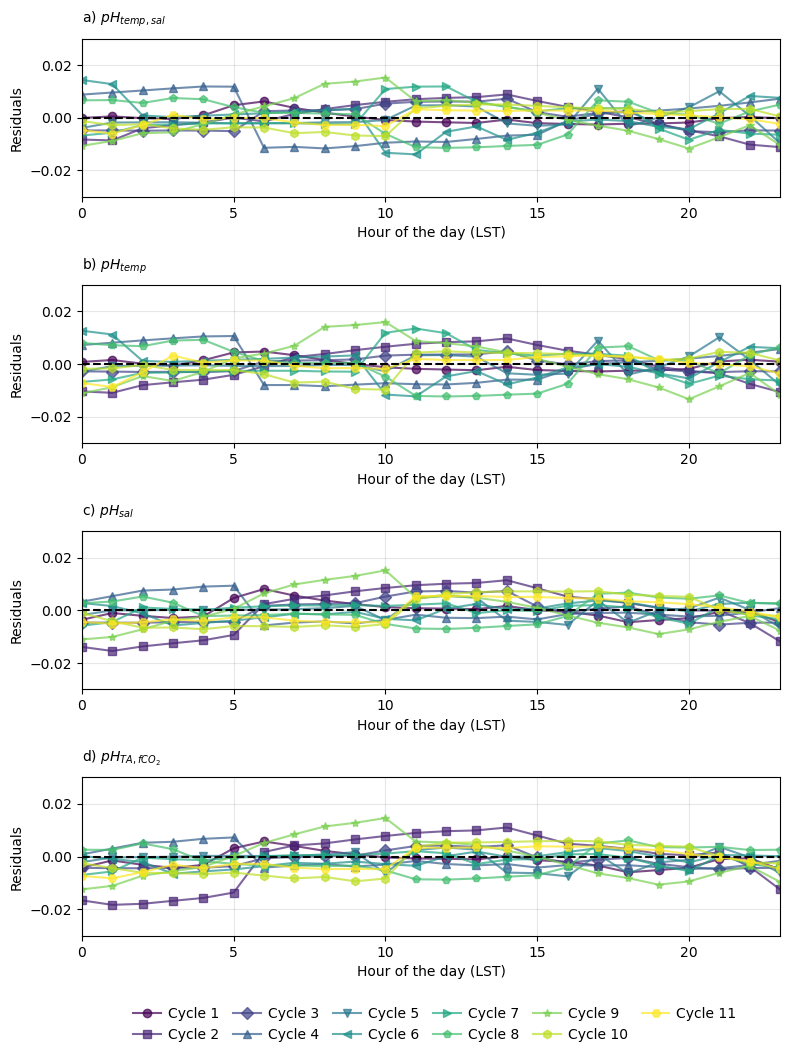

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate residuals and print statistics
def calculate_residuals(df, cycle_num):
    df['residuals_temp_sal'] = df['pH_TS_measured (optode)'] - df['pH_temp_sal']
    df['residuals_temp'] = df['pH_TS_measured (optode)'] - df['pH_temp']
    df['residuals_sal'] = df['pH_TS_measured (optode)'] - df['pH_sal']
    df['residuals_TA_DIC'] = df['pH_TS_measured (optode)'] - df['pH_TA_DIC']
    df['residuals_TA_fCO2'] = df['pH_TS_measured (optode)'] - df['pH_TA_fco2']
    
    # Print min, max, and mean residuals for each column
    residuals_cols = ['residuals_temp_sal', 'residuals_temp', 'residuals_sal', 'residuals_TA_DIC', 'residuals_TA_fCO2']
    for col in residuals_cols:
        print(f"Cycle {cycle_num} - {col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean()}")
    
    return df

# Apply the residuals calculation to each DataFrame in south_pacific_complete_cycles
south_pacific_residuals = [calculate_residuals(df.copy(), i+1) for i, df in enumerate(south_pacific_complete_cycles)]

# Define markers and colors for each cycle
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']
colors = plt.cm.viridis(np.linspace(0, 1, len(south_pacific_residuals)))

# Function to plot residuals with different colors and markers for each DataFrame
def plot_residuals(ax, dfs, column, label, colors, markers):
    for i, df in enumerate(dfs):
        ax.plot(df.index, df[column], marker=markers[i % len(markers)], color=colors[i], alpha=0.7, linestyle='-', label=f'Cycle {i+1}')
    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('Residuals')
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 23)
    ax.set_ylim(-0.03, 0.03)  # Set y-axis limits
    ax.axhline(0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
    ax.text(0, 1.1, label, transform=ax.transAxes)

# Initialize figure and axes
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

# Subplot labels
subplot_labels = ['a) $pH_{temp,sal}$', 'b) $pH_{temp}$', 'c) $pH_{sal}$', 'd) $pH_{TA, fCO_{2}}$']

# Subplot 1: Residuals for pH_temp_sal
plot_residuals(axes[0], south_pacific_residuals, 'residuals_temp_sal', subplot_labels[0], colors, markers)

# Subplot 2: Residuals for pH_temp
plot_residuals(axes[1], south_pacific_residuals, 'residuals_temp', subplot_labels[1], colors, markers)

# Subplot 3: Residuals for pH_sal
plot_residuals(axes[2], south_pacific_residuals, 'residuals_sal', subplot_labels[2], colors, markers)

# Subplot 4: Residuals for pH_TA_DIC
# plot_residuals(axes[3], south_pacific_residuals, 'residuals_TA_DIC', subplot_labels[3], colors, markers)

# Subplot 5: Residuals for pH_TA_fCO2
plot_residuals(axes[3], south_pacific_residuals, 'residuals_TA_fCO2', subplot_labels[3], colors, markers)

# Create a single legend below the last subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=(len(labels) + 1) // 2, bbox_to_anchor=(0.55, -0.06), frameon=False, columnspacing=1.0, handletextpad=0.5)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig("figs/SO289_residuals.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

plt.show()


### Extra figures to demonstrate theoretical pH sensitivity

#### DIC change due to pH sensitivity

In [37]:
# Initial conditions
TA = 2300  # Total Alkalinity in µmol/kg
DIC_initial = 2000  # Initial DIC in µmol/kg
salinity = 35  # Practical Salinity
temp_cold = 25  # Temperature in degrees Celsius, assuming 'cold' means normal ocean temp
pressure = 0  # Pressure in dbar

# Calculate the initial system
results_initial = pyco2.sys(par1=TA, par2=DIC_initial, par1_type=1, par2_type=2, 
                            salinity=salinity, temperature=temp_cold, pressure=pressure, 
                            total_phosphate=0, total_silicate=0)

# Extract the initial pH
initial_pH = results_initial['pH_total']  # Assuming pH scale is total scale

# Target pH
target_pH = initial_pH - 0.1  # Assuming you want to lower the pH by 0.1 units

# Function to find the DIC needed to reach the target pH
def find_target_dic(dic):
    results = pyco2.sys(par1=TA, par2=dic, par1_type=1, par2_type=2, 
                        salinity=salinity, temperature=temp_cold, pressure=pressure, 
                        total_phosphate=0, total_silicate=0)
    return results['pH_total'] - target_pH

# Use a numerical solver to find the required DIC
dic_target, = fsolve(find_target_dic, DIC_initial)

# Calculate the change in DIC
dic_change = dic_target - DIC_initial

# Constants
molecular_weight_C = 12.01  # g/mol
density_seawater = 1.025  # kg/L

# Convert µmol/kg to mg C/L
dic_change_mg_C_L = (dic_change / 1_000_000) * molecular_weight_C * 1_000 * density_seawater

# Convert mg C/L to mg C/m³
dic_change_mg_C_m3 = dic_change_mg_C_L * 1_000

# Calculate the daily change
dic_change_mg_C_m3_day = dic_change_mg_C_m3

# Output results
dic_change_mg_C_m3_day
print(f"A change in pH of 0.1 corresponds to {round(dic_change_mg_C_m3_day, 2)} mg C/m³/day")


A change in pH of 0.1 corresponds to 687.28 mg C/m³/day


In [38]:
# from scipy.optimize import fsolve

# # Initial conditions
# TA = 2300  # Total Alkalinity in µmol/kg
# DIC_initial = 2000  # Initial DIC in µmol/kg
# salinity = 35  # Practical Salinity
# temp_cold = 25  # Temperature in degrees Celsius, assuming 'cold' means normal ocean temp
# pressure = 0  # Pressure in dbar

# # Calculate the initial system
# results_initial = pyco2.sys(par1=TA, par2=DIC_initial, par1_type=1, par2_type=2, 
#                             salinity=salinity, temperature=temp_cold, pressure=pressure, 
#                             total_phosphate=0, total_silicate=0)

# # Extract the initial pH
# initial_pH = results_initial['pH_total']  # Assuming pH scale is total scale

# # Target pH
# target_pH = initial_pH - 0.1  # Assuming you want to lower the pH by 0.1 units

# # Function to find the DIC needed to reach the target pH
# def find_target_dic(dic):
#     results = pyco2.sys(par1=TA, par2=dic, par1_type=1, par2_type=2, 
#                         salinity=salinity, temperature=temp_cold, pressure=pressure, 
#                         total_phosphate=0, total_silicate=0)
#     return results['pH_total'] - target_pH

# # Use a numerical solver to find the required DIC
# dic_target, = fsolve(find_target_dic, DIC_initial)

# # Calculate the change in DIC
# dic_change = dic_target - DIC_initial

# # Output results
# DIC_initial, dic_target, dic_change

# print(f"A change in pH of 0.1 corresponds to {round(dic_change, 2)} umol/kg")

In [39]:
# # Constants
# molecular_weight_CO2 = 44.01  # g/mol
# density_seawater = 1.025  # kg/L

# # Convert µmol/kg to mg/L
# dic_change_mg_L = (dic_change / 1_000_000) * molecular_weight_CO2 * 1_000 * density_seawater
# dic_change_mg_L

# print(f"A change in pH of 0.1 corresponds to {round(dic_change_mg_L, 2)} mg/L for one day, assuming the 0.1 change in pH occured over a diurnal cycle.")

In [40]:
# dic_change_mg_L_day = dic_change_mg_L/24

# print(f"A change in pH of 0.1 corresponds to {round(dic_change_mg_L_day, 2)} mg/L/hour")

#### pH sensitivity due to temperature

In [41]:
# Constants for the example
TA = 2300  # Total alkalinity in µmol/kg
DIC = 2000  # Dissolved inorganic carbon in µmol/kg
salinity = 35  # Salinity in PSU
pressure = 0  # Surface pressure in dbar

# Temperatures in Celsius
temp_cold = 5  # Colder water temperature
temp_warm = 25  # Warmer water temperature

# Calculate pH and other parameters using PyCO2SYS at colder temperature
results_cold = pyco2.sys(par1=TA, par2=DIC, par1_type=1, par2_type=2, salinity=salinity, 
                         temperature=temp_cold, pressure=pressure, total_phosphate=0, total_silicate=0)

# Calculate pH and other parameters using PyCO2SYS at warmer temperature
results_warm = pyco2.sys(par1=TA, par2=DIC, par1_type=1, par2_type=2, salinity=salinity, 
                         temperature=temp_warm, pressure=pressure, total_phosphate=0, total_silicate=0)

# Extract pH values
pH_cold = results_cold["pH"]
pH_warm = results_warm["pH"]

pH_cold, pH_warm


(8.373445638361433, 8.047945242241319)

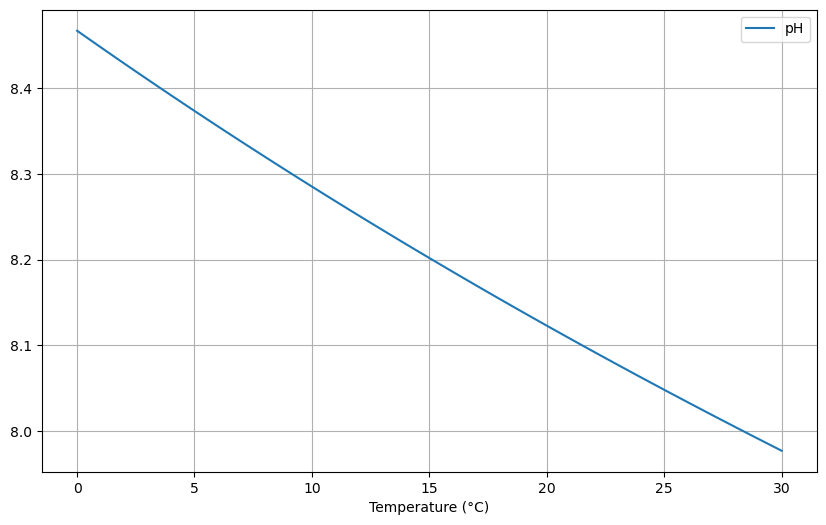

In [42]:
# Constants for the example
TA = 2300  # Total alkalinity in µmol/kg
DIC = 2000  # Dissolved inorganic carbon in µmol/kg
salinity = 35  # Salinity in PSU
pressure = 0  # Surface pressure in dbar

# Temperatures in Celsius for the range
temperatures = np.linspace(0, 30, 100)

# Calculate pH for each temperature
pH_values = []
for temp in temperatures:
    results = pyco2.sys(par1=TA, par2=DIC, par1_type=1, par2_type=2, salinity=salinity, 
                        temperature=temp, pressure=pressure, total_phosphate=0, total_silicate=0)
    pH_values.append(results["pH"])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(temperatures, pH_values, label='pH')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()
